# Importation of libraries and Data Collection

In [ ]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib # For plotting and visualization
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For statistical data visualization
import pickle  # For saving and loading objects

# Import machine learning libraries
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.linear_model import LinearRegression  # For linear regression modeling
from sklearn.feature_selection import RFECV, VarianceThreshold  # For feature selection methods
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.ensemble import RandomForestRegressor  # For random forest regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer  # For evaluating model performance
from sklearn.svm import SVR  # For support vector regression
from sklearn.model_selection import train_test_split, KFold  # For splitting data and cross-validation
from sklearn.dummy import DummyRegressor  # For creating baseline models
from sklearn.pipeline import Pipeline  # For creating machine learning pipelines
from xgboost import XGBRegressor  # For XGBoost regression
from sklearn import __version__ as sklearn_version  # For sklearn version
from xgboost import __version__ as xgboost_version  # For XGBoost version

# Import RDKit (cheminformatics toolkit)
!pip install rdkit-pypi  # Install RDKit library for working with chemical structures
from rdkit import Chem  # For handling chemical structure data
from rdkit.Chem import Descriptors  # For calculating molecular descriptors from chemical structures
from rdkit.ML.Descriptors import MoleculeDescriptors  # For handling molecular descriptors in machine learning
from rdkit import __version__ as rdkit_version  # For working with chemical structures

# Link to Google Drive to access datasets
from google.colab import drive  # Import Google Drive module to access files
drive.mount('/content/drive')  # Mount Google Drive to access files from the drive


# Extracting package versions
versions = {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "matplotlib": matplotlib.__version__,
    "seaborn": sns.__version__,
    "scikit-learn": sklearn_version,
    "xgboost": xgboost_version,
    "rdkit": rdkit_version,
}

# Print all versions
print("Package versions:")
for package, version in versions.items():
    print(f"{package}: {version}")


# Load datasets with file paths from Google Drive
file_paths = {
    'adenosine_deaminase': '/content/drive/My Drive/adenosine_deaminase.csv',  # Path for adenosine deaminase dataset
    'prostanoid_EP4': '/content/drive/My Drive/prostanoid_EP4.csv',  # Path for prostanoid EP4 dataset
    'interleukin_2': '/content/drive/My Drive/interleukin_2.csv',  # Path for interleukin 2 dataset
    'terpenes': '/content/drive/My Drive/terpenes.csv'  # Path for terpenes dataset
}


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 9.8 MB/s eta 0:00:00
Mounted at /content/drive
Package versions:
pandas: 2.1.4
numpy: 1.26.4
matplotlib: 3.7.1
seaborn: 0.13.1
scikit-learn: 1.3.2
xgboost: 2.1.1
rdkit: 2022.09.5


# Data Pre-processing and Features Selection

In [ ]:
# Function for checking the dimensions and features of the datasets
def check_features_and_dimensions(file_paths):
    for name, path in file_paths.items():  # Iterate through each dataset
        try:
            df = pd.read_csv(path, on_bad_lines='skip', engine='python')  # Load the dataset, skipping bad lines if any

            # Print dataset information
            print(f"Dataset: {name}")  # Print dataset name
            print(f"Number of rows: {df.shape[0]}")  # Print number of rows in the dataset
            print(f"Number of columns: {df.shape[1]}")  # Print number of columns in the dataset
            print("Column names:")  # Print column names
            print(df.columns.tolist())  # List column names
            print("\n" + "-"*50 + "\n")  # Print separator for readability
        except Exception as e:  # Handle any exceptions during dataset loading
            print(f"Error loading {name} dataset: {e}\n")  # Print error message

# Function to load and preprocess datasets with the target variable
def load_and_preprocess_dataset(file_path, target_column='pChEMBL Value'):
    dataset = pd.read_csv(file_path, on_bad_lines='skip', engine='python')  # Load the dataset, skipping bad lines

    print(f"Dimensions of the loaded dataset: {dataset.shape}")  # Print the dimensions of the loaded dataset

    print(f"Initial column names: {dataset.columns.tolist()}")  # Print the initial column names

    columns_to_drop = ['Comment', 'Uo Units', 'Data Validity Comment', 'Potential Duplicate']  # Define columns to drop
    dataset_clean = dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns])  # Drop unnecessary columns

    print(f"Column names after dropping unnecessary columns: {dataset_clean.columns.tolist()}")  # Print column names after dropping unnecessary columns

    missing_target_rows = dataset_clean[dataset_clean[target_column].isna()].shape[0]  # Count rows with missing target values
    print(f"Number of rows with missing target values: {missing_target_rows}")  # Print number of rows with missing target values

    dataset_clean = dataset_clean.dropna(subset=[target_column])  # Remove rows where the target variable is missing

    dataset_clean = dataset_clean[['Smiles', target_column]]  # Select only SMILES strings and the target variable

    descriptor_names = [desc[0] for desc in Descriptors._descList]  # Get names of molecular descriptors
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)  # Initialize descriptor calculator

    # Function to compute descriptors from SMILES strings
    def compute_descriptors(smiles):
        mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to a molecular structure
        if mol:
            descriptors = calculator.CalcDescriptors(mol)  # Calculate molecular descriptors
            return descriptors  # Return calculated descriptors
        else:
            return [None] * len(descriptor_names)  # Return None if SMILES conversion fails

    descriptor_values = dataset_clean['Smiles'].apply(compute_descriptors)  # Apply descriptor calculation to all SMILES strings
    descriptor_df = pd.DataFrame(descriptor_values.tolist(), columns=descriptor_names)  # Convert descriptors to DataFrame
    dataset_clean = pd.concat([dataset_clean.reset_index(drop=True), descriptor_df.reset_index(drop=True)], axis=1)  # Combine with original dataset

    print("First few rows of the dataset after adding descriptors:")  # Print first few rows of the dataset after adding descriptors
    print(dataset_clean.head())  # Display first few rows

    missing_values_before = dataset_clean[descriptor_names].isna().sum().sum()  # Count total missing values before imputation
    print(f"Total missing values before imputation: {missing_values_before}")  # Print total missing values before imputation

    imputer = SimpleImputer(strategy='mean')  # Initialize mean imputer
    dataset_clean[descriptor_names] = imputer.fit_transform(dataset_clean[descriptor_names])  # Impute missing values with the mean

    missing_values_after = dataset_clean[descriptor_names].isna().sum().sum()  # Count total missing values after imputation
    print(f"Total missing values after imputation: {missing_values_after}")  # Print total missing values after imputation

    print(f"Dimensions of the cleaned dataset: {dataset_clean.shape}")  # Print dimensions of the cleaned dataset

    # Pickle the cleaned dataset and descriptor names
    with open(f"{file_path.split('/')[-1].replace('.csv', '')}_cleaned_dataset.pkl", "wb") as f:
        pickle.dump((dataset_clean, descriptor_names), f)

    return dataset_clean, descriptor_names  # Return cleaned dataset and descriptor names

# Function to load and prepare the Terpenes dataset for predictions
def load_terpenes_for_prediction(file_path):
    dataset = pd.read_csv(file_path, on_bad_lines='skip', engine='python')  # Load the Terpenes dataset, skipping bad lines

    print(f"Dimensions of the loaded Terpenes dataset: {dataset.shape}")  # Print the dimensions of the loaded Terpenes dataset

    dataset_clean = dataset[['Name', 'Smiles']]  # Extract SMILES strings and Names

    descriptor_names = [desc[0] for desc in Descriptors._descList]  # Get names of molecular descriptors
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)  # Initialize descriptor calculator

    # Function to compute descriptors from SMILES strings
    def compute_descriptors(smiles):
        mol = Chem.MolFromSmiles(smiles)  # Convert SMILES to a molecular structure
        if mol:
            descriptors = calculator.CalcDescriptors(mol)  # Calculate molecular descriptors
            return descriptors  # Return calculated descriptors
        else:
            return [None] * len(descriptor_names)  # Return None if SMILES conversion fails

    descriptor_values = dataset_clean['Smiles'].apply(compute_descriptors)  # Apply descriptor calculation to all SMILES strings
    descriptor_df = pd.DataFrame(descriptor_values.tolist(), columns=descriptor_names)  # Convert descriptors to DataFrame
    dataset_clean = pd.concat([dataset_clean.reset_index(drop=True), descriptor_df.reset_index(drop=True)], axis=1)  # Combine with original dataset

    print(f"Dimensions of the Terpenes dataset after adding descriptors: {dataset_clean.shape}")  # Print dimensions of the Terpenes dataset after adding descriptors

    print("First few rows of the cleaned dataset after adding descriptors:")  # Print first few rows of the cleaned dataset after adding descriptors
    print(dataset_clean.head())  # Display first few rows

    # Pickle the cleaned Terpenes dataset and descriptor names
    with open(f"{file_path.split('/')[-1].replace('.csv', '')}_cleaned_dataset.pkl", "wb") as f:
        pickle.dump((dataset_clean, descriptor_names), f)

    return dataset_clean, descriptor_names  # Return cleaned Terpenes dataset and descriptor names

# Function to reduce features based on variance and correlation before RFE
def reduce_features(dataset, target_column, descriptor_names, variance_threshold=0.01, corr_threshold=0.95):
    selector = VarianceThreshold(threshold=variance_threshold)  # Initialize variance threshold selector
    X_var = selector.fit_transform(dataset[descriptor_names])  # Apply variance threshold to retain high-variance features
    retained_features = [descriptor_names[i] for i in range(len(descriptor_names)) if selector.get_support()[i]]  # List retained features

    corr_matrix = pd.DataFrame(X_var, columns=retained_features).corr().abs()  # Calculate correlation matrix of retained features
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Extract upper triangle of the correlation matrix

    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]  # Identify highly correlated features to drop
    retained_features = [feat for feat in retained_features if feat not in to_drop]  # Retain only non-correlated features

    print(f"Reduced features to {len(retained_features)} after variance and correlation filtering.")  # Print the number of reduced features

    # Pickle the reduced features
    with open(f"{dataset_name}_reduced_features.pkl", "wb") as f:
        pickle.dump(retained_features, f)

    return retained_features  # Return the final list of retained features

# Function to perform RFE with K-Fold cross-validation and plot the results, limiting to a max of 20 features
def perform_rfe_with_kfold(dataset, target_column, descriptor_names, n_splits=3, model_type='linear', max_features=20):
    X = dataset[descriptor_names]  # Extract features (descriptors) from the dataset
    y = dataset[target_column]  # Extract the target variable from the dataset

    if model_type == 'linear':  # Initialize the model based on user input
        model = LinearRegression()  # Use Linear Regression
    elif model_type == 'random_forest':  # Alternatively, use Random Forest
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError("Unsupported model type specified.")  # Raise an error if an unsupported model type is specified

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)  # Define K-Fold cross-validation with shuffling

    rfecv = RFECV(  # Define Recursive Feature Elimination with Cross-Validation
        estimator=model,
        step=2,  # Number of features to remove at each step
        cv=kf,  # Use K-Fold cross-validation
        scoring=make_scorer(mean_absolute_error, greater_is_better=False),  # Use negative MAE as the scoring metric
        n_jobs=-1,  # Use all available CPU cores
        min_features_to_select=1  # Minimum number of features to select
    )

    rfecv.fit(X, y)  # Fit the RFECV model on the data

    selected_feature_indices = np.where(rfecv.support_)[0]  # Get indices of selected features
    if len(selected_feature_indices) > max_features:  # Enforce a maximum feature limit
        selected_feature_indices = selected_feature_indices[:max_features]  # Cap the number of selected features

    selected_features = [descriptor_names[i] for i in selected_feature_indices]  # Get the names of the selected features

    reduced_dataset = dataset[selected_features + [target_column]]  # Create a reduced dataset with selected features and target variable

    print(f"Optimal number of features: {len(selected_features)} (capped at {max_features})")  # Print the optimal number of selected features

    plt.figure(figsize=(10, 6))  # Initialize a new plot with specific dimensions
    plt.title(f'RFE with Cross-Validation for {dataset_name}')  # Set plot title
    plt.xlabel('Number of Features Selected')  # Set x-axis label
    plt.ylabel('Cross-Validated Score (Negative MAE)')  # Set y-axis label

    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), -rfecv.cv_results_['mean_test_score'])  # Plot the number of features vs. cross-validated score
    plt.axvline(x=max_features, color='r', linestyle='--', label=f'Max {max_features} Features')  # Add a vertical line to indicate the max features limit
    plt.legend()  # Add a legend to the plot
    plt.show()  # Display the plot

    # Pickle the reduced dataset and selected features
    with open(f"{dataset_name}_reduced_dataset.pkl", "wb") as f:
        pickle.dump((reduced_dataset, selected_features), f)

    return reduced_dataset, selected_features  # Return the reduced dataset and selected features

# Function to perform Exploratory Data Analysis (EDA)
def perform_eda(dataset, target_column):
    print("Performing EDA...")  # Indicate the start of Exploratory Data Analysis

    # 1. Basic Statistics
    print("\nBasic Statistics:")  # Print section heading for basic statistics
    print(dataset.describe())  # Display descriptive statistics for the dataset

    # 2. Missing Values
    print("\nMissing Values per Column:")  # Print section heading for missing values
    print(dataset.isnull().sum())  # Display the number of missing values per column

    # 3. Distribution of the Target Variable
    plt.figure(figsize=(10, 6))  # Initialize a new plot with specific dimensions
    sns.histplot(dataset[target_column], kde=True, bins=30)  # Plot the distribution of the target variable with a histogram and KDE
    plt.title(f'Distribution of {target_column} for {dataset_name}')  # Set plot title
    plt.xlabel(target_column)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label
    plt.show()  # Display the plot

    # 4. Histograms for Numerical Features
    numerical_columns = dataset.select_dtypes(include=['float64', 'int64']).columns  # Select numerical columns in the dataset
    n_cols = 4  # Define the number of columns in the subplot grid
    n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Calculate the number of rows needed in the subplot grid

    plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Initialize a new plot grid with specific dimensions
    for i, col in enumerate(numerical_columns):  # Iterate through each numerical column
        plt.subplot(n_rows, n_cols, i + 1)  # Create a subplot for each column
        sns.histplot(dataset[col], kde=True, bins=30)  # Plot the distribution of the column with a histogram and KDE
        plt.title(col)  # Set subplot title as the column name

    plt.tight_layout()  # Adjust subplot layout to avoid overlap
    plt.show()  # Display the plot grid

    # 5. Correlation Heatmap
    plt.figure(figsize=(12, 8))  # Initialize a new plot with specific dimensions
    corr_matrix = dataset.corr()  # Calculate the correlation matrix of the dataset
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)  # Plot the correlation matrix as a heatmap
    plt.title(f'Correlation Heatmap for {dataset_name}')  # Set plot title
    plt.show()  # Display the heatmap


# Machine Learning Models with Evaluation and Comparison

In [ ]:
# Function to compare model performance with a baseline
def compare_with_baseline(X_train, y_train, X_test, y_test, model_name, dataset_name):
    baseline_model = DummyRegressor(strategy="mean")  # Initialize a Dummy Regressor as the baseline model
    baseline_model.fit(X_train, y_train)  # Fit the baseline model to the training data
    baseline_predictions = baseline_model.predict(X_test)  # Make predictions on the test data with the baseline model

    baseline_mae = mean_absolute_error(y_test, baseline_predictions)  # Calculate MAE for the baseline model
    baseline_mse = mean_squared_error(y_test, baseline_predictions)  # Calculate MSE for the baseline model
    baseline_rmse = np.sqrt(baseline_mse)  # Calculate RMSE for the baseline model
    baseline_r2 = r2_score(y_test, baseline_predictions)  # Calculate R² score for the baseline model

    print(f'\nBaseline evaluation for {model_name} on {dataset_name} dataset:')  # Print baseline evaluation heading
    print(f'Baseline MAE: {baseline_mae:.4f}')  # Print MAE of the baseline model
    print(f'Baseline MSE: {baseline_mse:.4f}')  # Print MSE of the baseline model
    print(f'Baseline RMSE: {baseline_rmse:.4f}')  # Print RMSE of the baseline model
    print(f'Baseline R²: {baseline_r2:.4f}')  # Print R² score of the baseline model

    return {
        'Baseline MAE': baseline_mae,  # Return the baseline MAE
        'Baseline MSE': baseline_mse,  # Return the baseline MSE
        'Baseline RMSE': baseline_rmse,  # Return the baseline RMSE
        'Baseline R²': baseline_r2  # Return the baseline R² score
    }

# Function to apply passive learning with selected models: XGBoost, Support Vector Machine, and Random Forest
def passive_learning_with_models(X_train, y_train, X_test, y_test, selected_feature_names, dataset_name, terpenes_df=None):
    models = {  # Define the models to be used in passive learning
        'Random Forest': RandomForestRegressor(random_state=42),  # Random Forest model
        'SVM': Pipeline([('scaler', StandardScaler()), ('svm', SVR())]),  # Support Vector Machine model with scaling
        'XGBoost': XGBRegressor(random_state=42)  # XGBoost model
    }

    results = {}  # Initialize a dictionary to store results

    for model_name, model in models.items():  # Iterate through each model
        print(f"\nTraining {model_name} on {dataset_name} dataset...")  # Print message indicating model training start
        model.fit(X_train, y_train)  # Fit the model on the training data
        y_pred = model.predict(X_test)  # Make predictions on the test data

        mae = mean_absolute_error(y_test, y_pred)  # Calculate MAE for the model
        mse = mean_squared_error(y_test, y_pred)  # Calculate MSE for the model
        rmse = np.sqrt(mse)  # Calculate RMSE for the model
        r2 = r2_score(y_test, y_pred)  # Calculate R² score for the model

        results[model_name] = {  # Store the metrics in the results dictionary
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        }

        baseline_results = compare_with_baseline(X_train, y_train, X_test, y_test, model_name, dataset_name)  # Compare with baseline model
        results[model_name].update(baseline_results)  # Update the results with baseline metrics

        print(f"\n{model_name} Results on {dataset_name} dataset:")  # Print model results heading
        print(f"  MAE: {mae:.4f}")  # Print MAE for the model
        print(f"  MSE: {mse:.4f}")  # Print MSE for the model
        print(f"  RMSE: {rmse:.4f}")  # Print RMSE for the model
        print(f"  R² Score: {r2:.4f}")  # Print R² score for the model

        # Check if terpenes_df is provided
        if terpenes_df is not None:
            print(f"\nPredictions for Terpenes dataset using {model_name} Passive Learning trained on {dataset_name}:")  # Print prediction heading for Terpenes
            terpenes_predictions = model.predict(terpenes_df[selected_feature_names].values)  # Predict on the Terpenes dataset
            terpenes_df['Prediction'] = terpenes_predictions  # Add predictions to the Terpenes DataFrame
            print(terpenes_df[['Name', 'Prediction']])  # Print Terpenes names and predictions

    # Pickle the results
    with open(f"{dataset_name}_passive_results.pkl", "wb") as f:
        pickle.dump(results, f)

    # Plotting the metrics for all models in separate bar plots
    metrics = ['MAE', 'MSE', 'RMSE', 'R²']  # Define the metrics to plot
    colors = ['blue', 'orange', 'green']  # Define colors for the bar plots
    model_names = list(models.keys())  # Get model names

    # Creating a dictionary to hold the metric values for each model
    metric_values = {metric: [results[model][metric] for model in model_names] for metric in metrics}  # Store metric values for each model

    # Creating a figure with 4 subplots (one per metric)
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))  # Create a figure with subplots

    for i, metric in enumerate(metrics):  # Iterate through each metric
        axes[i].bar(model_names, metric_values[metric], color=colors)  # Create a bar plot for each metric
        axes[i].set_title(f'{metric} on {dataset_name}')  # Set the title for each subplot
        axes[i].set_xlabel('Models')  # Set the x-axis label
        axes[i].set_ylabel(metric)  # Set the y-axis label

        # Annotate the bars with their height
        for j, value in enumerate(metric_values[metric]):  # Iterate through each bar
            axes[i].annotate(f'{value:.2f}', xy=(j, value), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')  # Annotate the bar with the metric value

    # Add a main title
    fig.suptitle(f'Performance Metrics by Model on {dataset_name} for Passive Learning', fontsize=16)  # Add a main title to the figure

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
    plt.show()  # Display the plots

    return results  # Return the results dictionary

# Active Learning for XGBoost
def active_learning_xgboost(df_final, selected_feature_names, terpenes_df, dataset_name):
    X = df_final[selected_feature_names].values  # Extract features (descriptors) from the final dataset
    y = df_final['pChEMBL Value'].values  # Extract the target variable from the final dataset

    X_initial_train, X_test, y_initial_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and test sets
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_initial_train, y_initial_train, test_size=0.8, random_state=42)  # Further split training data into labeled and unlabeled sets

    model = XGBRegressor(random_state=42)  # Initialize XGBoost model
    model.fit(X_labeled, y_labeled)  # Fit the model on the labeled data
    initial_accuracy = model.score(X_test, y_test)  # Calculate initial accuracy on the test set
    print(f'Initial accuracy (R²) for {dataset_name} with XGBoost: {initial_accuracy:.4f}')  # Print initial accuracy

    batch_size = 5  # Define the batch size for active learning
    max_queries = len(y_unlabeled) // batch_size  # Calculate the maximum number of queries

    r2_scores = [initial_accuracy]  # Initialize list to store R² scores
    mae_scores = []  # Initialize list to store MAE scores
    mse_scores = []  # Initialize list to store MSE scores
    rmse_scores = []  # Initialize list to store RMSE scores
    labeled_percentages = [len(y_labeled) / len(y) * 100]  # Initialize list to store the percentage of labeled samples

    for _ in range(max_queries):  # Perform active learning in batches
        y_unlabeled_pred = model.predict(X_unlabeled)  # Predict on the unlabeled data
        uncertainties = np.abs(y_unlabeled_pred - y_unlabeled.mean())  # Calculate uncertainties
        query_idx = uncertainties.argsort()[-batch_size:]  # Select the most uncertain samples

        X_labeled = np.vstack([X_labeled, X_unlabeled[query_idx]])  # Add queried samples to the labeled set
        y_labeled = np.hstack([y_labeled, y_unlabeled[query_idx]])  # Add corresponding labels to the labeled set

        X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)  # Remove queried samples from the unlabeled set
        y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)  # Remove corresponding labels from the unlabeled set

        labeled_percentage = len(y_labeled) / len(y) * 100  # Calculate the percentage of labeled samples
        labeled_percentages.append(labeled_percentage)  # Append the percentage to the list

        model.fit(X_labeled, y_labeled)  # Retrain the model on the expanded labeled set
        accuracy = model.score(X_test, y_test)  # Calculate accuracy on the test set
        r2_scores.append(accuracy)  # Append the R² score to the list

        y_pred = model.predict(X_test)  # Predict on the test set
        mae = mean_absolute_error(y_test, y_pred)  # Calculate MAE on the test set
        mse = mean_squared_error(y_test, y_pred)  # Calculate MSE on the test set
        rmse = np.sqrt(mse)  # Calculate RMSE on the test set

        mae_scores.append(mae)  # Append MAE to the list
        mse_scores.append(mse)  # Append MSE to the list
        rmse_scores.append(rmse)  # Append RMSE to the list

    results = {  # Store final results
        'MAE': mae_scores[-1],  # Return the final MAE
        'MSE': mse_scores[-1],  # Return the final MSE
        'RMSE': rmse_scores[-1],  # Return the final RMSE
        'R²': r2_scores[-1]  # Return the final R² score
    }

    # Pickle the active learning results
    with open(f"{dataset_name}_xgboost_active_results.pkl", "wb") as f:
        pickle.dump(results, f)

    plot_metrics(labeled_percentages, r2_scores, mae_scores, mse_scores, rmse_scores, dataset_name, model_name='XGBoost')  # Plot metrics over labeled samples

    if terpenes_df is not None:  # Check if Terpenes dataset is provided
        print(f"\nPredictions for Terpenes dataset using XGBoost Active Learning trained on {dataset_name}:")  # Print prediction heading for Terpenes
        terpenes_predictions = model.predict(terpenes_df[selected_feature_names].values)  # Predict on the Terpenes dataset
        terpenes_df['Prediction'] = terpenes_predictions  # Add predictions to the Terpenes DataFrame
        print(terpenes_df[['Name', 'Prediction']])  # Print Terpenes names and predictions

    return results  # Return the final results dictionary

# Active Learning for SVM
def active_learning_svm(df_final, selected_feature_names, terpenes_df, dataset_name):
    X = df_final[selected_feature_names].values  # Extract features (descriptors) from the final dataset
    y = df_final['pChEMBL Value'].values  # Extract the target variable from the final dataset

    X_initial_train, X_test, y_initial_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and test sets
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_initial_train, y_initial_train, test_size=0.8, random_state=42)  # Further split training data into labeled and unlabeled sets

    model = Pipeline([  # Initialize SVM model with scaling
        ('scaler', StandardScaler()),  # Scale the features
        ('svm', SVR())  # Use Support Vector Regressor
    ])

    model.fit(X_labeled, y_labeled)  # Fit the model on the labeled data
    initial_accuracy = model.score(X_test, y_test)  # Calculate initial accuracy on the test set
    print(f'Initial accuracy (R²) for {dataset_name} with SVM: {initial_accuracy:.4f}')  # Print initial accuracy

    batch_size = 5  # Define the batch size for active learning
    max_queries = len(y_unlabeled) // batch_size  # Calculate the maximum number of queries

    r2_scores = [initial_accuracy]  # Initialize list to store R² scores
    mae_scores = []  # Initialize list to store MAE scores
    mse_scores = []  # Initialize list to store MSE scores
    rmse_scores = []  # Initialize list to store RMSE scores
    labeled_percentages = [len(y_labeled) / len(y) * 100]  # Initialize list to store the percentage of labeled samples

    for _ in range(max_queries):  # Perform active learning in batches
        y_unlabeled_pred = model.predict(X_unlabeled)  # Predict on the unlabeled data
        uncertainties = np.abs(y_unlabeled_pred - y_unlabeled.mean())  # Calculate uncertainties
        query_idx = uncertainties.argsort()[-batch_size:]  # Select the most uncertain samples

        X_labeled = np.vstack([X_labeled, X_unlabeled[query_idx]])  # Add queried samples to the labeled set
        y_labeled = np.hstack([y_labeled, y_unlabeled[query_idx]])  # Add corresponding labels to the labeled set

        X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)  # Remove queried samples from the unlabeled set
        y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)  # Remove corresponding labels from the unlabeled set

        labeled_percentage = len(y_labeled) / len(y) * 100  # Calculate the percentage of labeled samples
        labeled_percentages.append(labeled_percentage)  # Append the percentage to the list

        model.fit(X_labeled, y_labeled)  # Retrain the model on the expanded labeled set
        accuracy = model.score(X_test, y_test)  # Calculate accuracy on the test set
        r2_scores.append(accuracy)  # Append the R² score to the list

        y_pred = model.predict(X_test)  # Predict on the test set
        mae = mean_absolute_error(y_test, y_pred)  # Calculate MAE on the test set
        mse = mean_squared_error(y_test, y_pred)  # Calculate MSE on the test set
        rmse = np.sqrt(mse)  # Calculate RMSE on the test set

        mae_scores.append(mae)  # Append MAE to the list
        mse_scores.append(mse)  # Append MSE to the list
        rmse_scores.append(rmse)  # Append RMSE to the list

    results = {  # Store final results
        'MAE': mae_scores[-1],  # Return the final MAE
        'MSE': mse_scores[-1],  # Return the final MSE
        'RMSE': rmse_scores[-1],  # Return the final RMSE
        'R²': r2_scores[-1]  # Return the final R² score
    }

    # Pickle the active learning results
    with open(f"{dataset_name}_svm_active_results.pkl", "wb") as f:
        pickle.dump(results, f)

    plot_metrics(labeled_percentages, r2_scores, mae_scores, mse_scores, rmse_scores, dataset_name, model_name='SVM')  # Plot metrics over labeled samples

    if terpenes_df is not None:  # Check if Terpenes dataset is provided
        print(f"\nPredictions for Terpenes dataset using SVM Active Learning trained on {dataset_name}:")  # Print prediction heading for Terpenes
        terpenes_predictions = model.predict(terpenes_df[selected_feature_names].values)  # Predict on the Terpenes dataset
        terpenes_df['Prediction'] = terpenes_predictions  # Add predictions to the Terpenes DataFrame
        print(terpenes_df[['Name', 'Prediction']])  # Print Terpenes names and predictions

    return results  # Return the final results dictionary

# Active Learning for Random Forest
def active_learning_random_forest(df_final, selected_feature_names, terpenes_df, dataset_name):
    X = df_final[selected_feature_names].values  # Extract features (descriptors) from the final dataset
    y = df_final['pChEMBL Value'].values  # Extract the target variable from the final dataset

    X_initial_train, X_test, y_initial_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and test sets
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_initial_train, y_initial_train, test_size=0.8, random_state=42)  # Further split training data into labeled and unlabeled sets

    model = RandomForestRegressor(random_state=42)  # Initialize Random Forest model
    model.fit(X_labeled, y_labeled)  # Fit the model on the labeled data
    initial_accuracy = model.score(X_test, y_test)  # Calculate initial accuracy on the test set
    print(f'Initial accuracy (R²) for {dataset_name} with Random Forest: {initial_accuracy:.4f}')  # Print initial accuracy

    batch_size = 5  # Define the batch size for active learning
    max_queries = len(y_unlabeled) // batch_size  # Calculate the maximum number of queries

    r2_scores = [initial_accuracy]  # Initialize list to store R² scores
    mae_scores = []  # Initialize list to store MAE scores
    mse_scores = []  # Initialize list to store MSE scores
    rmse_scores = []  # Initialize list to store RMSE scores
    labeled_percentages = [len(y_labeled) / len(y) * 100]  # Initialize list to store the percentage of labeled samples

    for _ in range(max_queries):  # Perform active learning in batches
        y_unlabeled_pred = model.predict(X_unlabeled)  # Predict on the unlabeled data
        uncertainties = np.abs(y_unlabeled_pred - y_unlabeled.mean())  # Calculate uncertainties
        query_idx = uncertainties.argsort()[-batch_size:]  # Select the most uncertain samples

        X_labeled = np.vstack([X_labeled, X_unlabeled[query_idx]])  # Add queried samples to the labeled set
        y_labeled = np.hstack([y_labeled, y_unlabeled[query_idx]])  # Add corresponding labels to the labeled set

        X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)  # Remove queried samples from the unlabeled set
        y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)  # Remove corresponding labels from the unlabeled set

        labeled_percentage = len(y_labeled) / len(y) * 100  # Calculate the percentage of labeled samples
        labeled_percentages.append(labeled_percentage)  # Append the percentage to the list

        model.fit(X_labeled, y_labeled)  # Retrain the model on the expanded labeled set
        accuracy = model.score(X_test, y_test)  # Calculate accuracy on the test set
        r2_scores.append(accuracy)  # Append the R² score to the list

        y_pred = model.predict(X_test)  # Predict on the test set
        mae = mean_absolute_error(y_test, y_pred)  # Calculate MAE on the test set
        mse = mean_squared_error(y_test, y_pred)  # Calculate MSE on the test set
        rmse = np.sqrt(mse)  # Calculate RMSE on the test set

        mae_scores.append(mae)  # Append MAE to the list
        mse_scores.append(mse)  # Append MSE to the list
        rmse_scores.append(rmse)  # Append RMSE to the list

    results = {  # Store final results
        'MAE': mae_scores[-1],  # Return the final MAE
        'MSE': mse_scores[-1],  # Return the final MSE
        'RMSE': rmse_scores[-1],  # Return the final RMSE
        'R²': r2_scores[-1]  # Return the final R² score
    }

    # Pickle the active learning results
    with open(f"{dataset_name}_random_forest_active_results.pkl", "wb") as f:
        pickle.dump(results, f)

    plot_metrics(labeled_percentages, r2_scores, mae_scores, mse_scores, rmse_scores, dataset_name, model_name='Random Forest')  # Plot metrics over labeled samples

    if terpenes_df is not None:  # Check if Terpenes dataset is provided
        print(f"\nPredictions for Terpenes dataset using Random Forest Active Learning trained on {dataset_name}:")  # Print prediction heading for Terpenes
        terpenes_predictions = model.predict(terpenes_df[selected_feature_names].values)  # Predict on the Terpenes dataset
        terpenes_df['Prediction'] = terpenes_predictions  # Add predictions to the Terpenes DataFrame
        print(terpenes_df[['Name', 'Prediction']])  # Print Terpenes names and predictions

    return results  # Return the final results dictionary

# Function to compare active and passive learning
def compare_learning_methods(comparison_results):
    for dataset_name, results in comparison_results.items():  # Iterate through each dataset
        print(f"\nComparing Passive and Active Learning for dataset: {dataset_name}")  # Print comparison heading for the dataset

        model_names = ['XGBoost', 'SVM', 'Random Forest']  # Define the model names to compare

        for model_name in model_names:  # Iterate through each model name
            if model_name in results['Passive Learning']:  # Check if the model is in passive learning results
                if model_name in results['Active Learning']:  # Check if the model is in active learning results
                    print(f"\nComparing Passive and Active Learning for {model_name}:")  # Print comparison heading for the model
                    passive_metrics = results['Passive Learning'][model_name]  # Get passive learning metrics
                    active_metrics = results['Active Learning'][model_name]  # Get active learning metrics

                    metrics = ['MAE', 'MSE', 'RMSE', 'R²']  # Define the metrics to compare
                    if all(metric in passive_metrics and metric in active_metrics for metric in metrics):  # Check if all metrics are available
                        passive_values = [passive_metrics[metric] for metric in metrics]  # Get passive learning metric values
                        active_values = [active_metrics[metric] for metric in metrics]  # Get active learning metric values

                        fig, ax = plt.subplots(figsize=(12, 7))  # Create a new plot
                        x = range(len(metrics))  # Define x-axis values
                        width = 0.4  # Width of the bars

                        # Plot Passive Learning metrics
                        bars1 = ax.bar(x, passive_values, width=width, label='Passive Learning', align='center')

                        # Plot Active Learning metrics
                        bars2 = ax.bar([p + width for p in x], active_values, width=width, label='Active Learning', align='center')

                        ax.set_xticks([p + width / 2 for p in x])  # Set x-ticks
                        ax.set_xticklabels(metrics)  # Set x-tick labels
                        ax.set_title(f"Comparison of Metrics for {model_name} on {dataset_name}")  # Set plot title
                        ax.set_ylabel('Score')  # Set y-axis label
                        ax.legend()  # Add a legend to the plot

                        # Annotate Passive Learning bars with their values
                        for bar in bars1:
                            yval = bar.get_height()
                            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

                        # Annotate Active Learning bars with their values
                        for bar in bars2:
                            yval = bar.get_height()
                            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

                        plt.show()  # Display the plot

                        for metric in metrics:  # Iterate through each metric
                            passive_value = passive_metrics[metric]  # Get passive learning value
                            active_value = active_metrics[metric]  # Get active learning value
                            if metric == 'R²':  # Compare R² scores
                                better_method = 'Active Learning' if active_value > passive_value else 'Passive Learning'  # Determine the better method
                            else:  # Compare other metrics
                                better_method = 'Active Learning' if active_value < passive_value else 'Passive Learning'  # Determine the better method
                            print(f"{metric}: {better_method} performed better.")  # Print the better method for the metric
                    else:
                        print(f"Metrics are missing for {model_name}. Ensure both Passive and Active Learning contain all metrics.")  # Print error if metrics are missing
                else:
                    print(f"Model '{model_name}' is missing in Active Learning results for {dataset_name}.")  # Print error if model is missing in active learning results
            else:
                print(f"Model '{model_name}' is missing in Passive Learning results for {dataset_name}.")  # Print error if model is missing in passive learning results

# Function to plot metrics over labeled samples
def plot_metrics(labeled_percentages, r2_scores, mae_scores, mse_scores, rmse_scores, dataset_name, model_name):
    if r2_scores:  # Check if R² scores are available
        plt.figure(figsize=(10, 6))  # Create a new plot for R² scores
        plt.plot(labeled_percentages, r2_scores, marker='o', linestyle='-', color='b', label='R²')  # Plot R² scores over labeled percentages
        plt.title(f'R² Score vs Labeled Samples ({dataset_name}, {model_name}, Active Learning)')  # Set plot title
        plt.xlabel('Labeled Samples (%)')  # Set x-axis label
        plt.ylabel('R² Score')  # Set y-axis label
        plt.ylim(-1, 1)  # Set y-axis limits
        plt.legend()  # Add a legend to the plot
        plt.grid(True)  # Add grid lines to the plot
        plt.show()  # Display the plot

    if mae_scores:  # Check if MAE scores are available
        plt.figure(figsize=(10, 6))  # Create a new plot for MAE scores
        plt.plot(labeled_percentages[1:], mae_scores, marker='o', linestyle='-', color='r', label='MAE')  # Plot MAE scores over labeled percentages
        plt.title(f'MAE vs Labeled Samples ({dataset_name}, {model_name}, Active Learning)')  # Set plot title
        plt.xlabel('Labeled Samples (%)')  # Set x-axis label
        plt.ylabel('MAE')  # Set y-axis label
        plt.legend()  # Add a legend to the plot
        plt.grid(True)  # Add grid lines to the plot
        plt.show()  # Display the plot

    if mse_scores:  # Check if MSE scores are available
        plt.figure(figsize=(10, 6))  # Create a new plot for MSE scores
        plt.plot(labeled_percentages[1:], mse_scores, marker='o', linestyle='-', color='g', label='MSE')  # Plot MSE scores over labeled percentages
        plt.title(f'MSE vs Labeled Samples ({dataset_name}, {model_name}, Active Learning)')  # Set plot title
        plt.xlabel('Labeled Samples (%)')  # Set x-axis label
        plt.ylabel('MSE')  # Set y-axis label
        plt.legend()  # Add a legend to the plot
        plt.grid(True)  # Add grid lines to the plot
        plt.show()  # Display the plot

    if rmse_scores:  # Check if RMSE scores are available
        plt.figure(figsize=(10, 6))  # Create a new plot for RMSE scores
        plt.plot(labeled_percentages[1:], rmse_scores, marker='o', linestyle='-', color='m', label='RMSE')  # Plot RMSE scores over labeled percentages
        plt.title(f'RMSE vs Labeled Samples ({dataset_name}, {model_name}, Active Learning)')  # Set plot title
        plt.xlabel('Labeled Samples (%)')  # Set x-axis label
        plt.ylabel('RMSE')  # Set y-axis label
        plt.legend()  # Add a legend to the plot
        plt.grid(True)  # Add grid lines to the plot
        plt.show()  # Display the plot

    if r2_scores:  # Check if R² scores are available
        print(f"Final R²: {r2_scores[-1]:.4f}")  # Print the final R² score
    if mae_scores:  # Check if MAE scores are available
        print(f"Final MAE: {mae_scores[-1]:.4f}")  # Print the final MAE
    if mse_scores:  # Check if MSE scores are available
        print(f"Final MSE: {mse_scores[-1]:.4f}")  # Print the final MSE
    if rmse_scores:  # Check if RMSE scores are available
        print(f"Final RMSE: {rmse_scores[-1]:.4f}")  # Print the final RMSE

# Function to determine the best-performing model across datasets and whether active learning was better
def summarize_best_performance(comparison_results):
    summary = {}  # Initialize a dictionary to store the summary

    for dataset_name, results in comparison_results.items():
        print(f"\nSummary for {dataset_name} dataset:")

        best_model_passive = None
        best_model_active = None
        best_aggregate_score_passive = float('inf')
        best_aggregate_score_active = float('inf')

        for model_name in results['Passive Learning']:
            passive_metrics = results['Passive Learning'][model_name]
            active_metrics = results['Active Learning'].get(model_name, None)

            # Normalize and aggregate scores for passive learning
            passive_aggregate_score = (
                passive_metrics['MAE'] +
                passive_metrics['MSE'] +
                passive_metrics['RMSE'] -
                passive_metrics['R²']
            )

            # Normalize and aggregate scores for active learning
            if active_metrics:
                active_aggregate_score = (
                    active_metrics['MAE'] +
                    active_metrics['MSE'] +
                    active_metrics['RMSE'] -
                    active_metrics['R²']
                )

                if active_aggregate_score < best_aggregate_score_active:
                    best_aggregate_score_active = active_aggregate_score
                    best_model_active = model_name

            if passive_aggregate_score < best_aggregate_score_passive:
                best_aggregate_score_passive = passive_aggregate_score
                best_model_passive = model_name

        print(f"  Best Model (Passive Learning): {best_model_passive} with Aggregated Score = {best_aggregate_score_passive:.4f}")
        print(f"  Best Model (Active Learning): {best_model_active} with Aggregated Score = {best_aggregate_score_active:.4f}")

        active_better = best_aggregate_score_active < best_aggregate_score_passive
        summary[dataset_name] = {
            'Best Model (Passive)': best_model_passive,
            'Best Model (Active)': best_model_active,
            'Active Learning Better': active_better
        }

        if active_better:
            print("  Active Learning outperformed Passive Learning.")
        else:
            print("  Passive Learning outperformed Active Learning or was equal.")

    return summary

# Function to determine the best-performing model for each dataset for both passive and active learning
def print_best_model_per_dataset(summary):
    print("\nBest Performing Models Across Datasets:")

    for dataset_name, result in summary.items():
        best_passive_model = result['Best Model (Passive)']
        best_active_model = result['Best Model (Active)']
        active_better = result['Active Learning Better']

        print(f"\nDataset: {dataset_name}")
        print(f"  Best Passive Learning Model: {best_passive_model}")
        print(f"  Best Active Learning Model: {best_active_model}")
        if active_better:
            print("  Active Learning was better.")
        else:
            print("  Passive Learning was better or performed equally.")

# Workflow Application to all datasets

Dataset: adenosine_deaminase
Number of rows: 739
Number of columns: 47
Column names:
['CHEMBL2966', 'Molecule Name', 'Molecule Max Phase', 'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key', 'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment', 'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate', 'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation', 'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type', 'Document ChEMBL ID', 'Source ID', 'Source Description', 'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties', 'Action Type', 'Standard Text Value']

---------------------

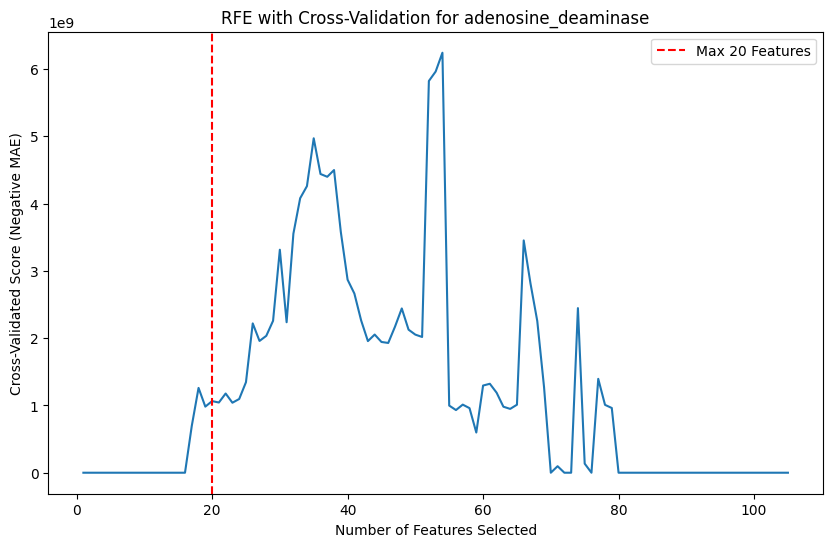

Performing EDA...

Basic Statistics:
              qed       MolWt  ExactMolWt  MinPartialCharge  \
count  285.000000  285.000000  285.000000        285.000000   
mean     0.654483  301.224098  300.991778         -0.410086   
std      0.136890   53.553876   53.484217          0.044408   
min      0.086203  180.211000  180.101111         -0.744036   
25%      0.577204  267.245000  267.096754         -0.396375   
50%      0.684662  288.359000  288.181093         -0.393567   
75%      0.757835  330.344000  330.132805         -0.391258   
max      0.907256  602.398000  602.115210         -0.381731   

       MaxAbsPartialCharge  BCUT2D_LOGPLOW      BalabanJ       Chi4n  \
count           285.000000      285.000000  2.850000e+02  285.000000   
mean              0.417385       -2.221207  1.980479e+00    2.541618   
std               0.081032        0.097754  3.999834e-01    0.609432   
min               0.381731       -2.588039  2.103750e-07    1.260091   
25%               0.391258       -2

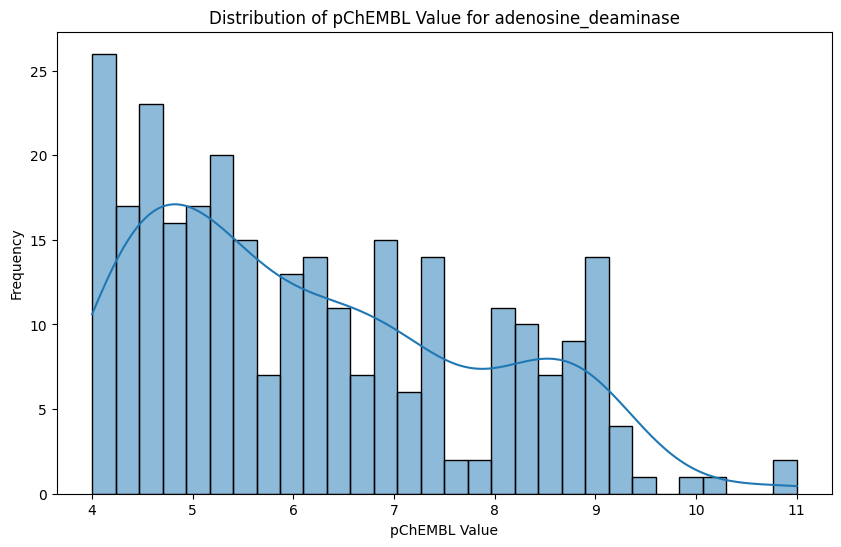

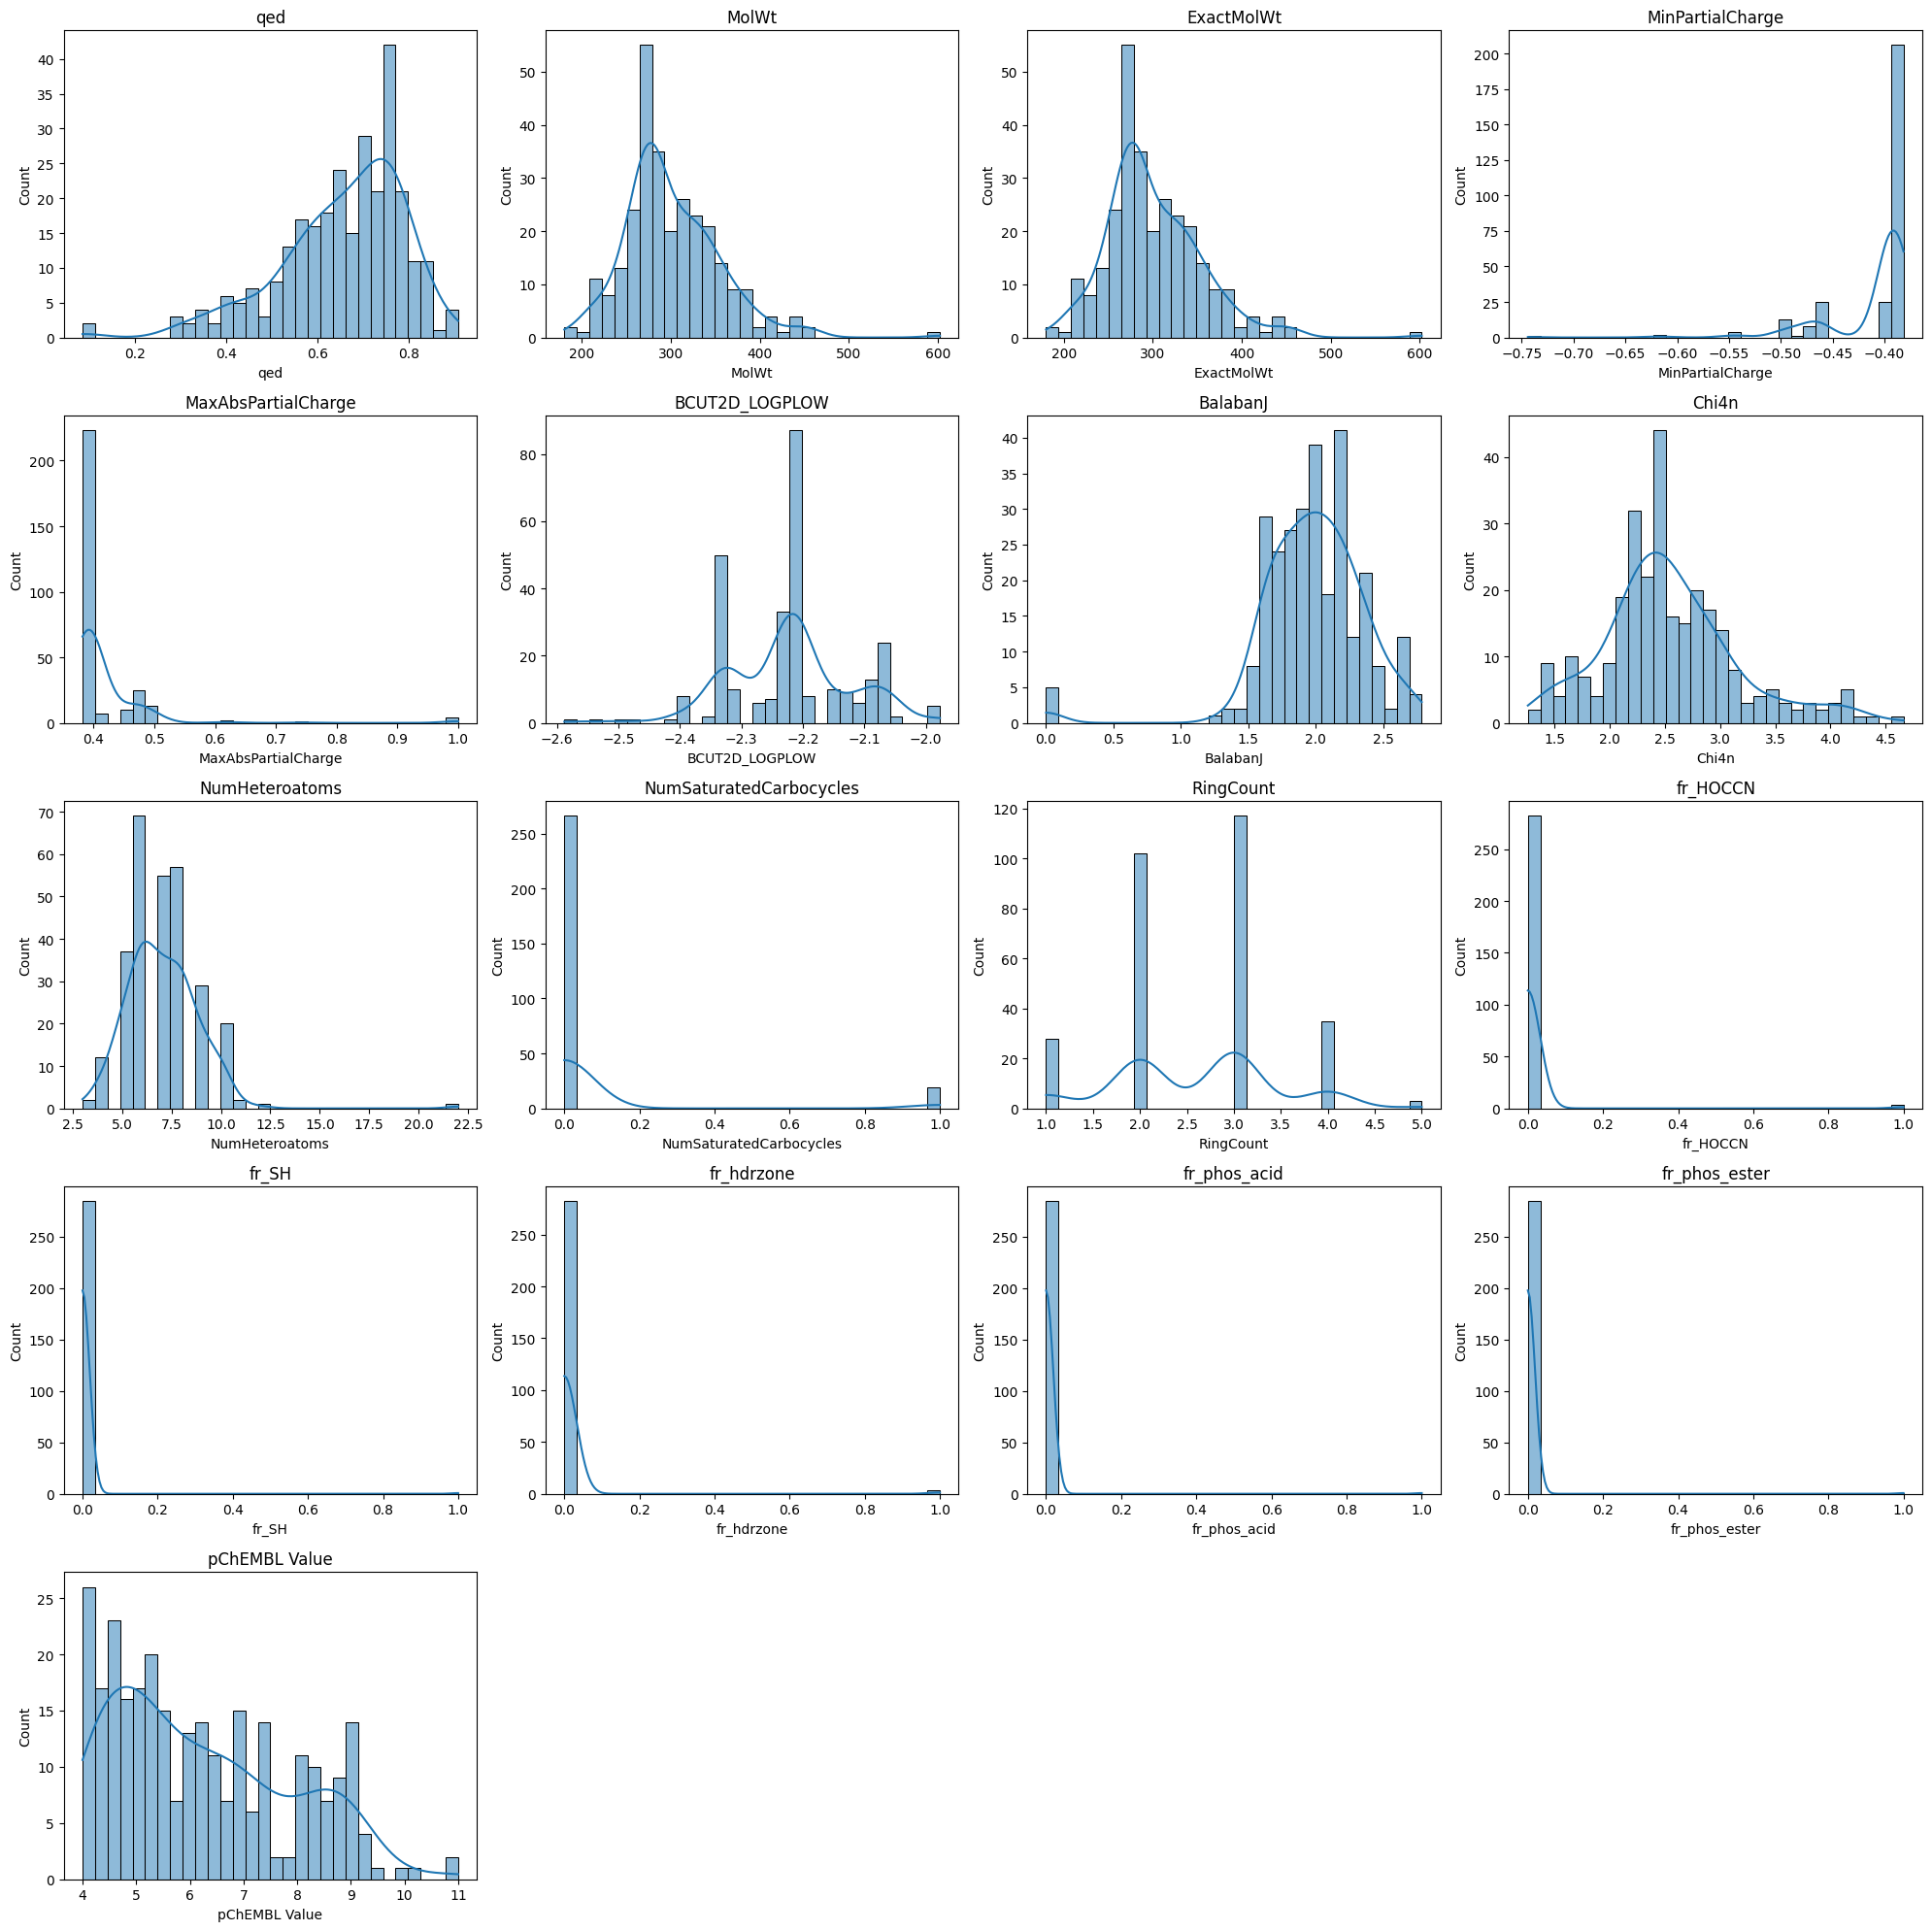

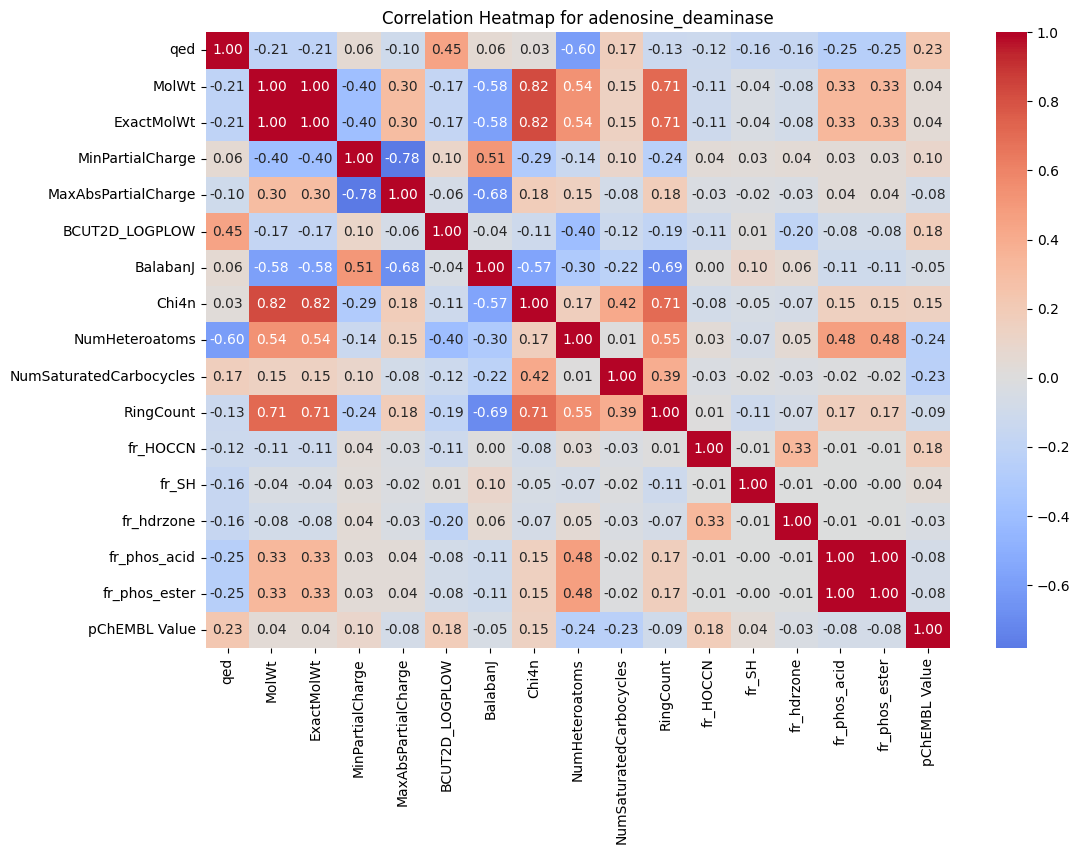


Applying Passive Learning...

Training Random Forest on adenosine_deaminase dataset...

Baseline evaluation for Random Forest on adenosine_deaminase dataset:
Baseline MAE: 1.3420
Baseline MSE: 2.6054
Baseline RMSE: 1.6141
Baseline R²: -0.0017

Random Forest Results on adenosine_deaminase dataset:
  MAE: 0.7344
  MSE: 0.9705
  RMSE: 0.9851
  R² Score: 0.6269

Predictions for Terpenes dataset using Random Forest Passive Learning trained on adenosine_deaminase:
                   Name  Prediction
0       Alpha Bisabolol    6.099957
1               Cedrene    6.407725
2    Alpha Phellandrene    4.687398
3          Alpha Pinene    6.001508
4       Alpha Terpineol    4.724111
5    Beta Caryophyllene    5.947825
6           Beta Pinene    6.073358
7               Borneol    4.772798
8              Camphene    6.982479
9               Camphor    5.863908
10  Caryophyllene Oxide    6.735495
11               Citral    4.744298
12          Citronellol    5.191800
13       Delta 3 Carene    6.750

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Baseline evaluation for XGBoost on adenosine_deaminase dataset:
Baseline MAE: 1.3420
Baseline MSE: 2.6054
Baseline RMSE: 1.6141
Baseline R²: -0.0017

XGBoost Results on adenosine_deaminase dataset:
  MAE: 0.7319
  MSE: 1.0149
  RMSE: 1.0074
  R² Score: 0.6098

Predictions for Terpenes dataset using XGBoost Passive Learning trained on adenosine_deaminase:
                   Name  Prediction
0       Alpha Bisabolol    6.215132
1               Cedrene    6.065206
2    Alpha Phellandrene    4.625532
3          Alpha Pinene    5.975266
4       Alpha Terpineol    4.571985
5    Beta Caryophyllene    5.483914
6           Beta Pinene    5.956043
7               Borneol    4.701518
8              Camphene    6.017345
9               Camphor    5.668835
10  Caryophyllene Oxide    6.175190
11               Citral    4.596167
12          Citronellol    5.175107
13       Delta 3 Carene    6.091008
14           D-Limonene    4.647340
15           Eucalyptol    5.679789
16              Eugenol    5.0

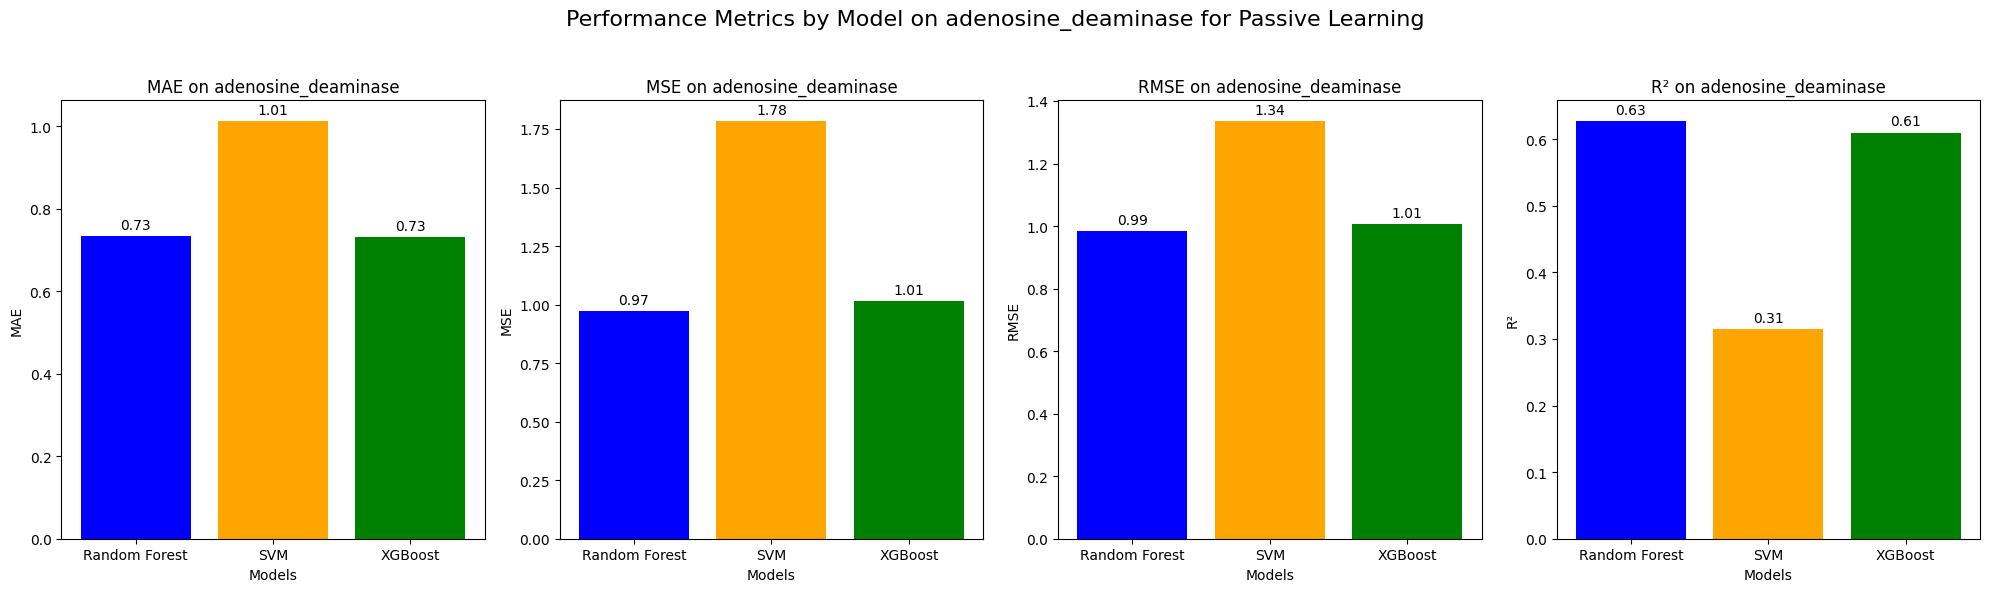


Passive Learning Results:
Random Forest:
  MAE: 0.7344
  MSE: 0.9705
  RMSE: 0.9851
  R²: 0.6269
  Baseline MAE: 1.3420
  Baseline MSE: 2.6054
  Baseline RMSE: 1.6141
  Baseline R²: -0.0017
SVM:
  MAE: 1.0127
  MSE: 1.7831
  RMSE: 1.3353
  R²: 0.3144
  Baseline MAE: 1.3420
  Baseline MSE: 2.6054
  Baseline RMSE: 1.6141
  Baseline R²: -0.0017
XGBoost:
  MAE: 0.7319
  MSE: 1.0149
  RMSE: 1.0074
  R²: 0.6098
  Baseline MAE: 1.3420
  Baseline MSE: 2.6054
  Baseline RMSE: 1.6141
  Baseline R²: -0.0017

Applying Active Learning with XGBoost...
Initial accuracy (R²) for adenosine_deaminase with XGBoost: 0.2199


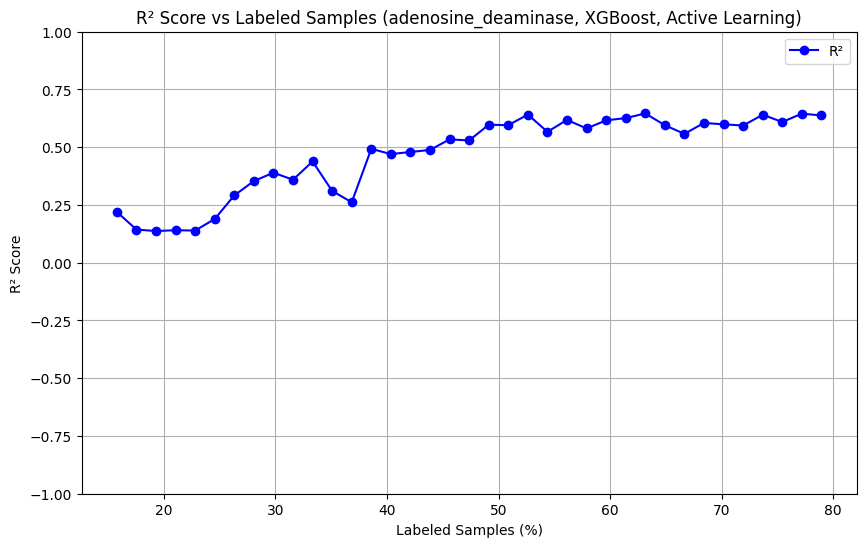

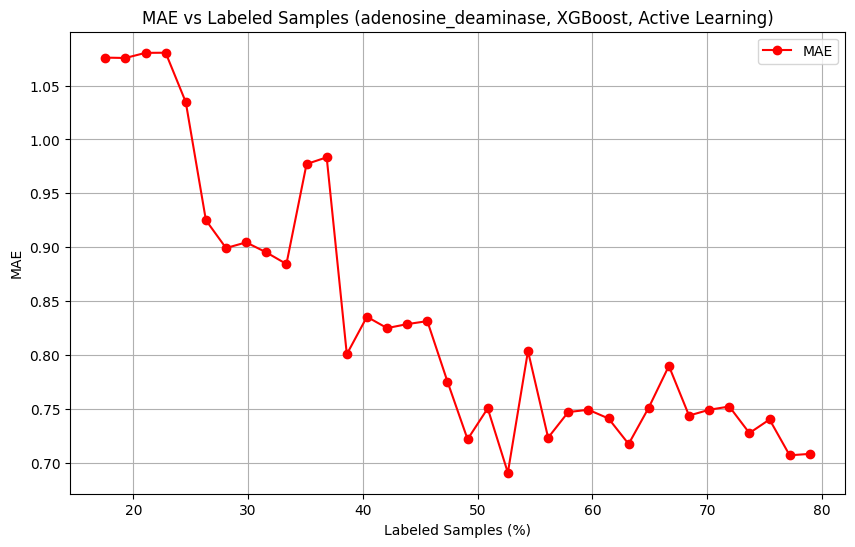

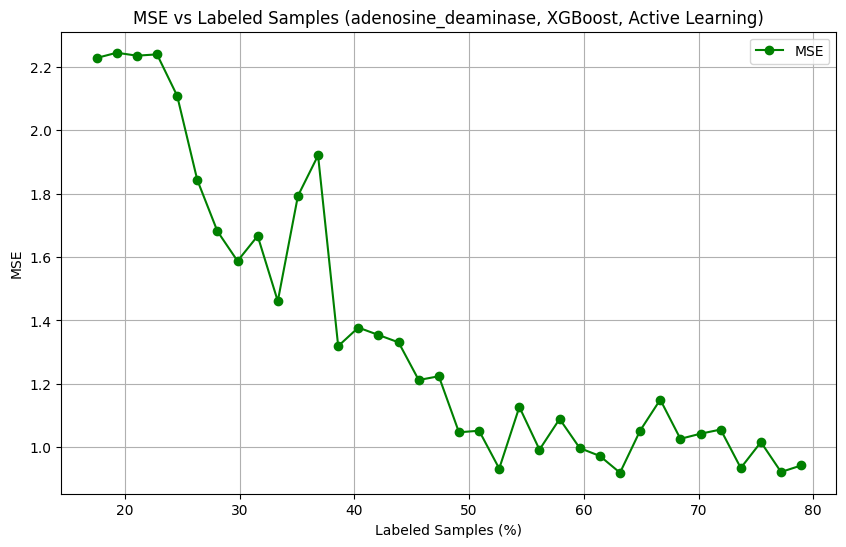

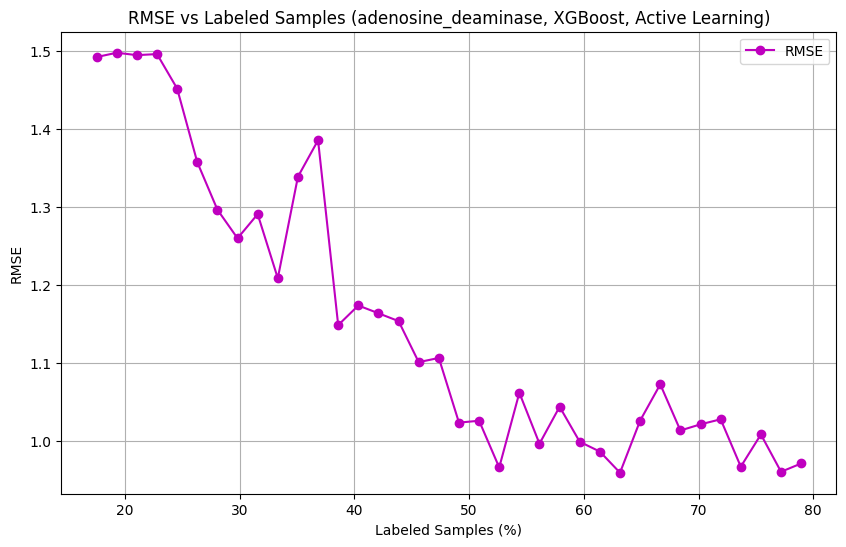

Final R²: 0.6375
Final MAE: 0.7083
Final MSE: 0.9428
Final RMSE: 0.9710

Predictions for Terpenes dataset using XGBoost Active Learning trained on adenosine_deaminase:
                   Name  Prediction
0       Alpha Bisabolol    6.540238
1               Cedrene    5.904869
2    Alpha Phellandrene    4.665180
3          Alpha Pinene    5.762106
4       Alpha Terpineol    4.632969
5    Beta Caryophyllene    5.003434
6           Beta Pinene    5.757756
7               Borneol    4.859304
8              Camphene    6.309688
9               Camphor    5.738699
10  Caryophyllene Oxide    6.354788
11               Citral    4.733877
12          Citronellol    5.409175
13       Delta 3 Carene    6.411701
14           D-Limonene    4.665189
15           Eucalyptol    5.904044
16              Eugenol    5.507235
17      Alpha Farnesene    4.725577
18       Bata Farnesene    4.713724
19              Fenchol    4.843482
20      Gamma Terpinene    4.704838
21             Geraniol    5.641490
22  

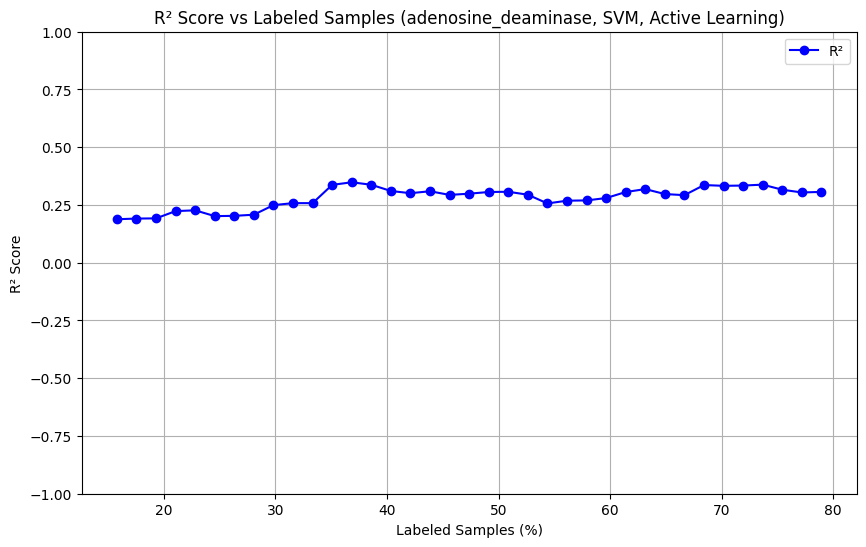

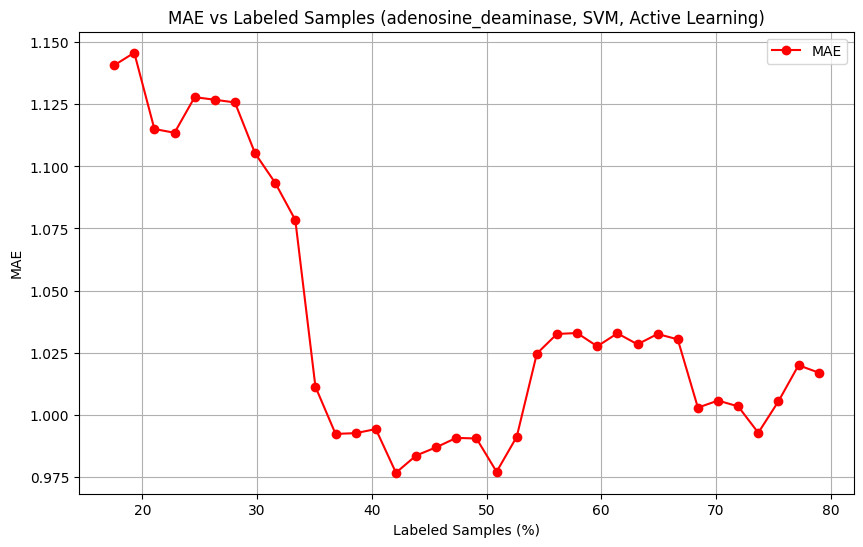

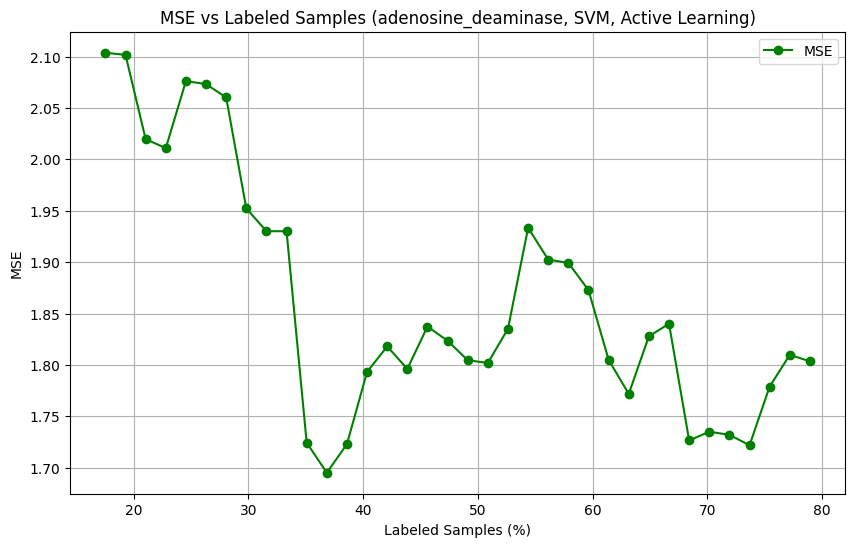

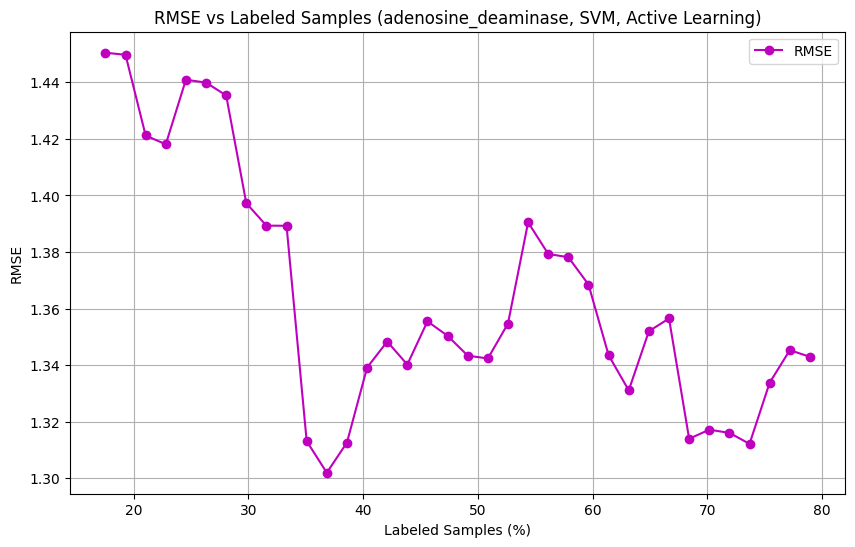

Final R²: 0.3066
Final MAE: 1.0169
Final MSE: 1.8036
Final RMSE: 1.3430

Predictions for Terpenes dataset using SVM Active Learning trained on adenosine_deaminase:
                   Name  Prediction
0       Alpha Bisabolol    4.664455
1               Cedrene    5.143037
2    Alpha Phellandrene    5.141672
3          Alpha Pinene    5.142775
4       Alpha Terpineol    4.415724
5    Beta Caryophyllene    5.142400
6           Beta Pinene    5.143087
7               Borneol    5.131332
8              Camphene    5.143042
9               Camphor    5.137350
10  Caryophyllene Oxide    5.121017
11               Citral    5.142349
12          Citronellol    4.978046
13       Delta 3 Carene    5.143004
14           D-Limonene    5.140728
15           Eucalyptol    5.074038
16              Eugenol    4.983806
17      Alpha Farnesene    5.143140
18       Bata Farnesene    5.143144
19              Fenchol    5.132649
20      Gamma Terpinene    5.142365
21             Geraniol    5.116809
22      

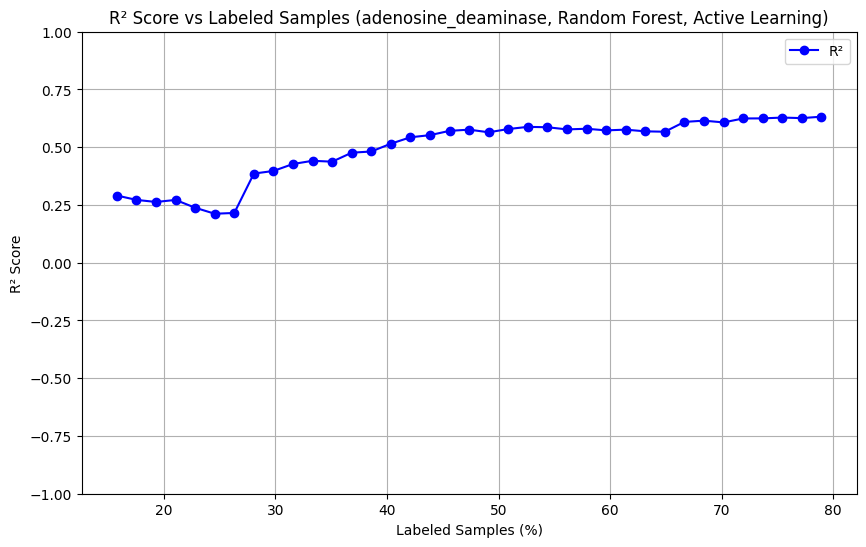

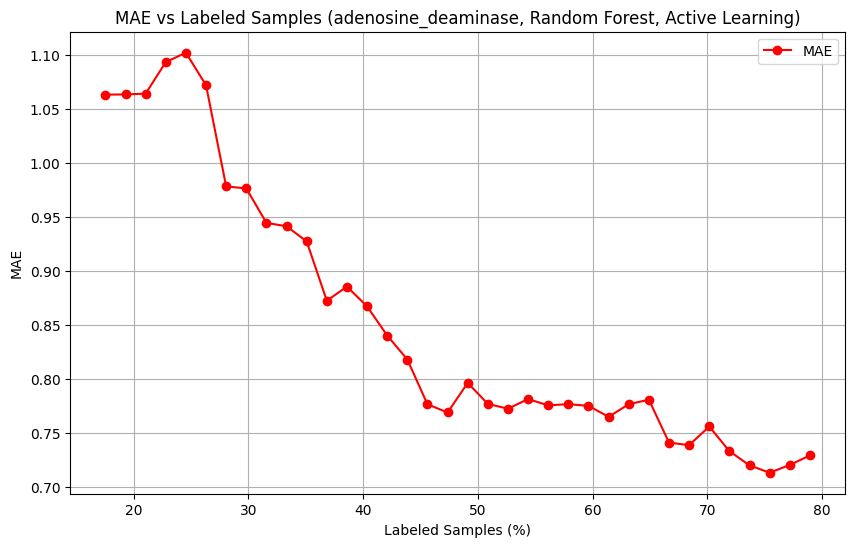

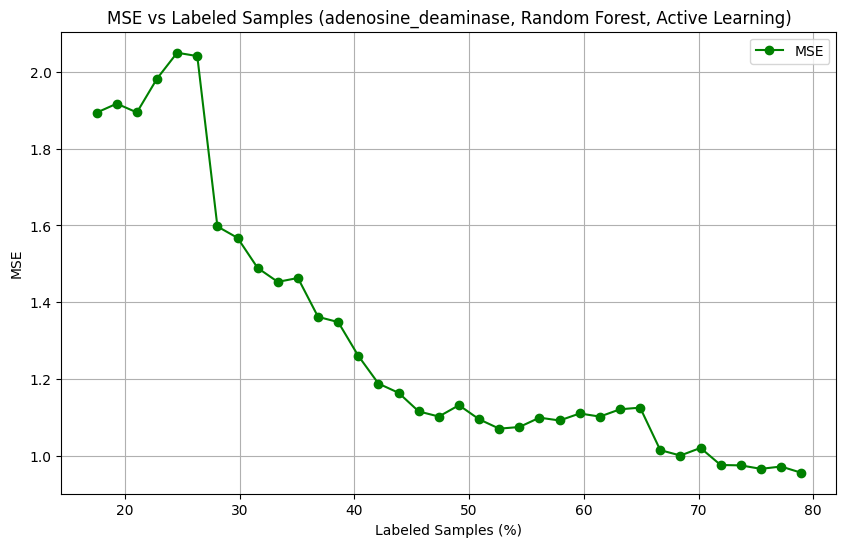

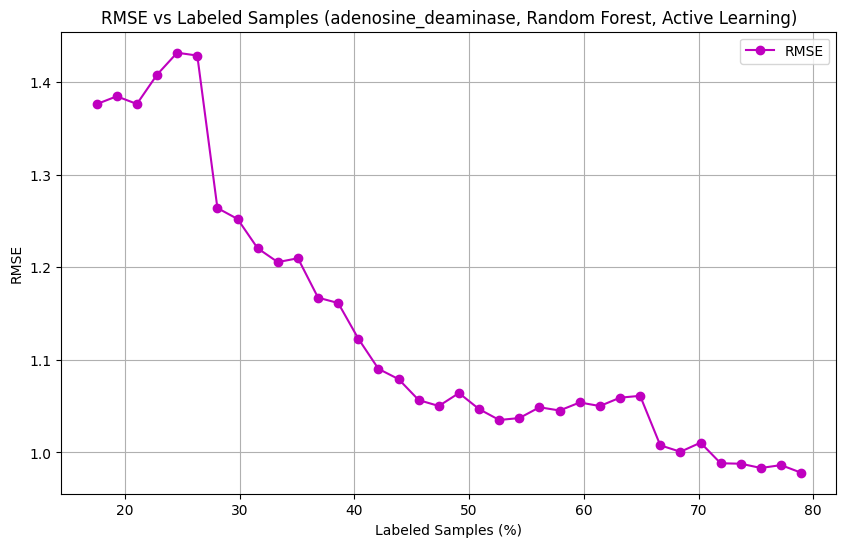

Final R²: 0.6322
Final MAE: 0.7291
Final MSE: 0.9566
Final RMSE: 0.9780

Predictions for Terpenes dataset using Random Forest Active Learning trained on adenosine_deaminase:
                   Name  Prediction
0       Alpha Bisabolol    6.428302
1               Cedrene    6.433875
2    Alpha Phellandrene    4.725477
3          Alpha Pinene    6.267838
4       Alpha Terpineol    4.832967
5    Beta Caryophyllene    6.174975
6           Beta Pinene    6.260438
7               Borneol    4.979778
8              Camphene    6.824415
9               Camphor    6.242838
10  Caryophyllene Oxide    6.888575
11               Citral    4.725477
12          Citronellol    5.220175
13       Delta 3 Carene    6.659172
14           D-Limonene    4.763427
15           Eucalyptol    6.477443
16              Eugenol    5.289375
17      Alpha Farnesene    4.725477
18       Bata Farnesene    4.725477
19              Fenchol    5.293545
20      Gamma Terpinene    4.725477
21             Geraniol    5.31850

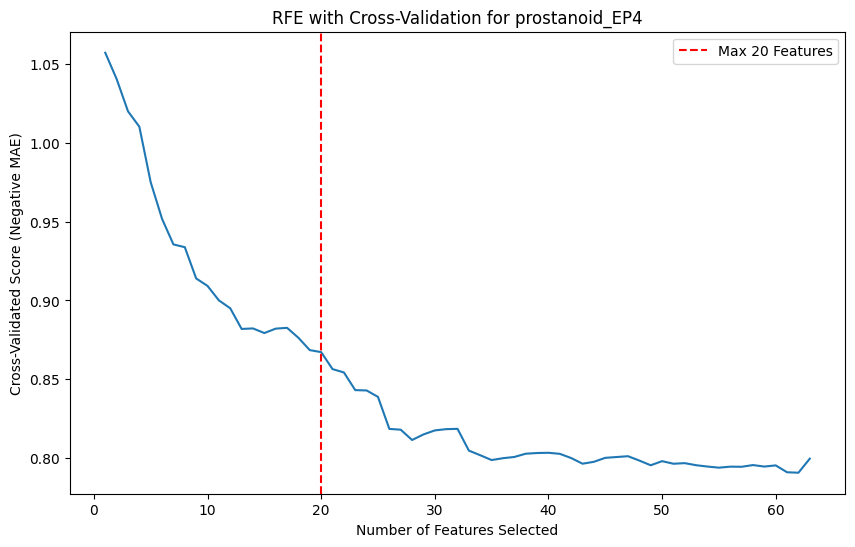

Performing EDA...

Basic Statistics:
       MaxEStateIndex  MinEStateIndex  MinAbsEStateIndex          qed  \
count     1266.000000     1266.000000        1266.000000  1266.000000   
mean        12.880203       -2.147102           0.103858     0.423810   
std          0.978768        1.656557           0.109746     0.158402   
min          3.981153       -6.000000           0.000000     0.046727   
25%         12.291195       -3.988619           0.034886     0.307086   
50%         13.006550       -1.012157           0.077156     0.404201   
75%         13.571266       -0.933194           0.149171     0.548455   
max         14.970306        0.805706           0.805706     0.832581   

             MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_CHGHI  \
count  1266.000000       1266.000000  1266.000000   1266.000000   
mean    471.745612          1.060751    27.327873      2.304394   
std      95.953176          0.173297    11.976756      0.122292   
min     264.324000          0.407407 

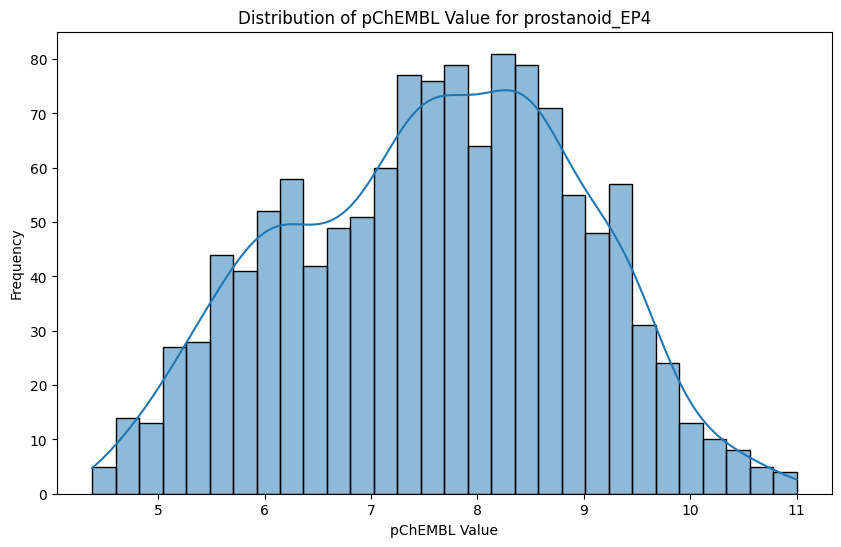

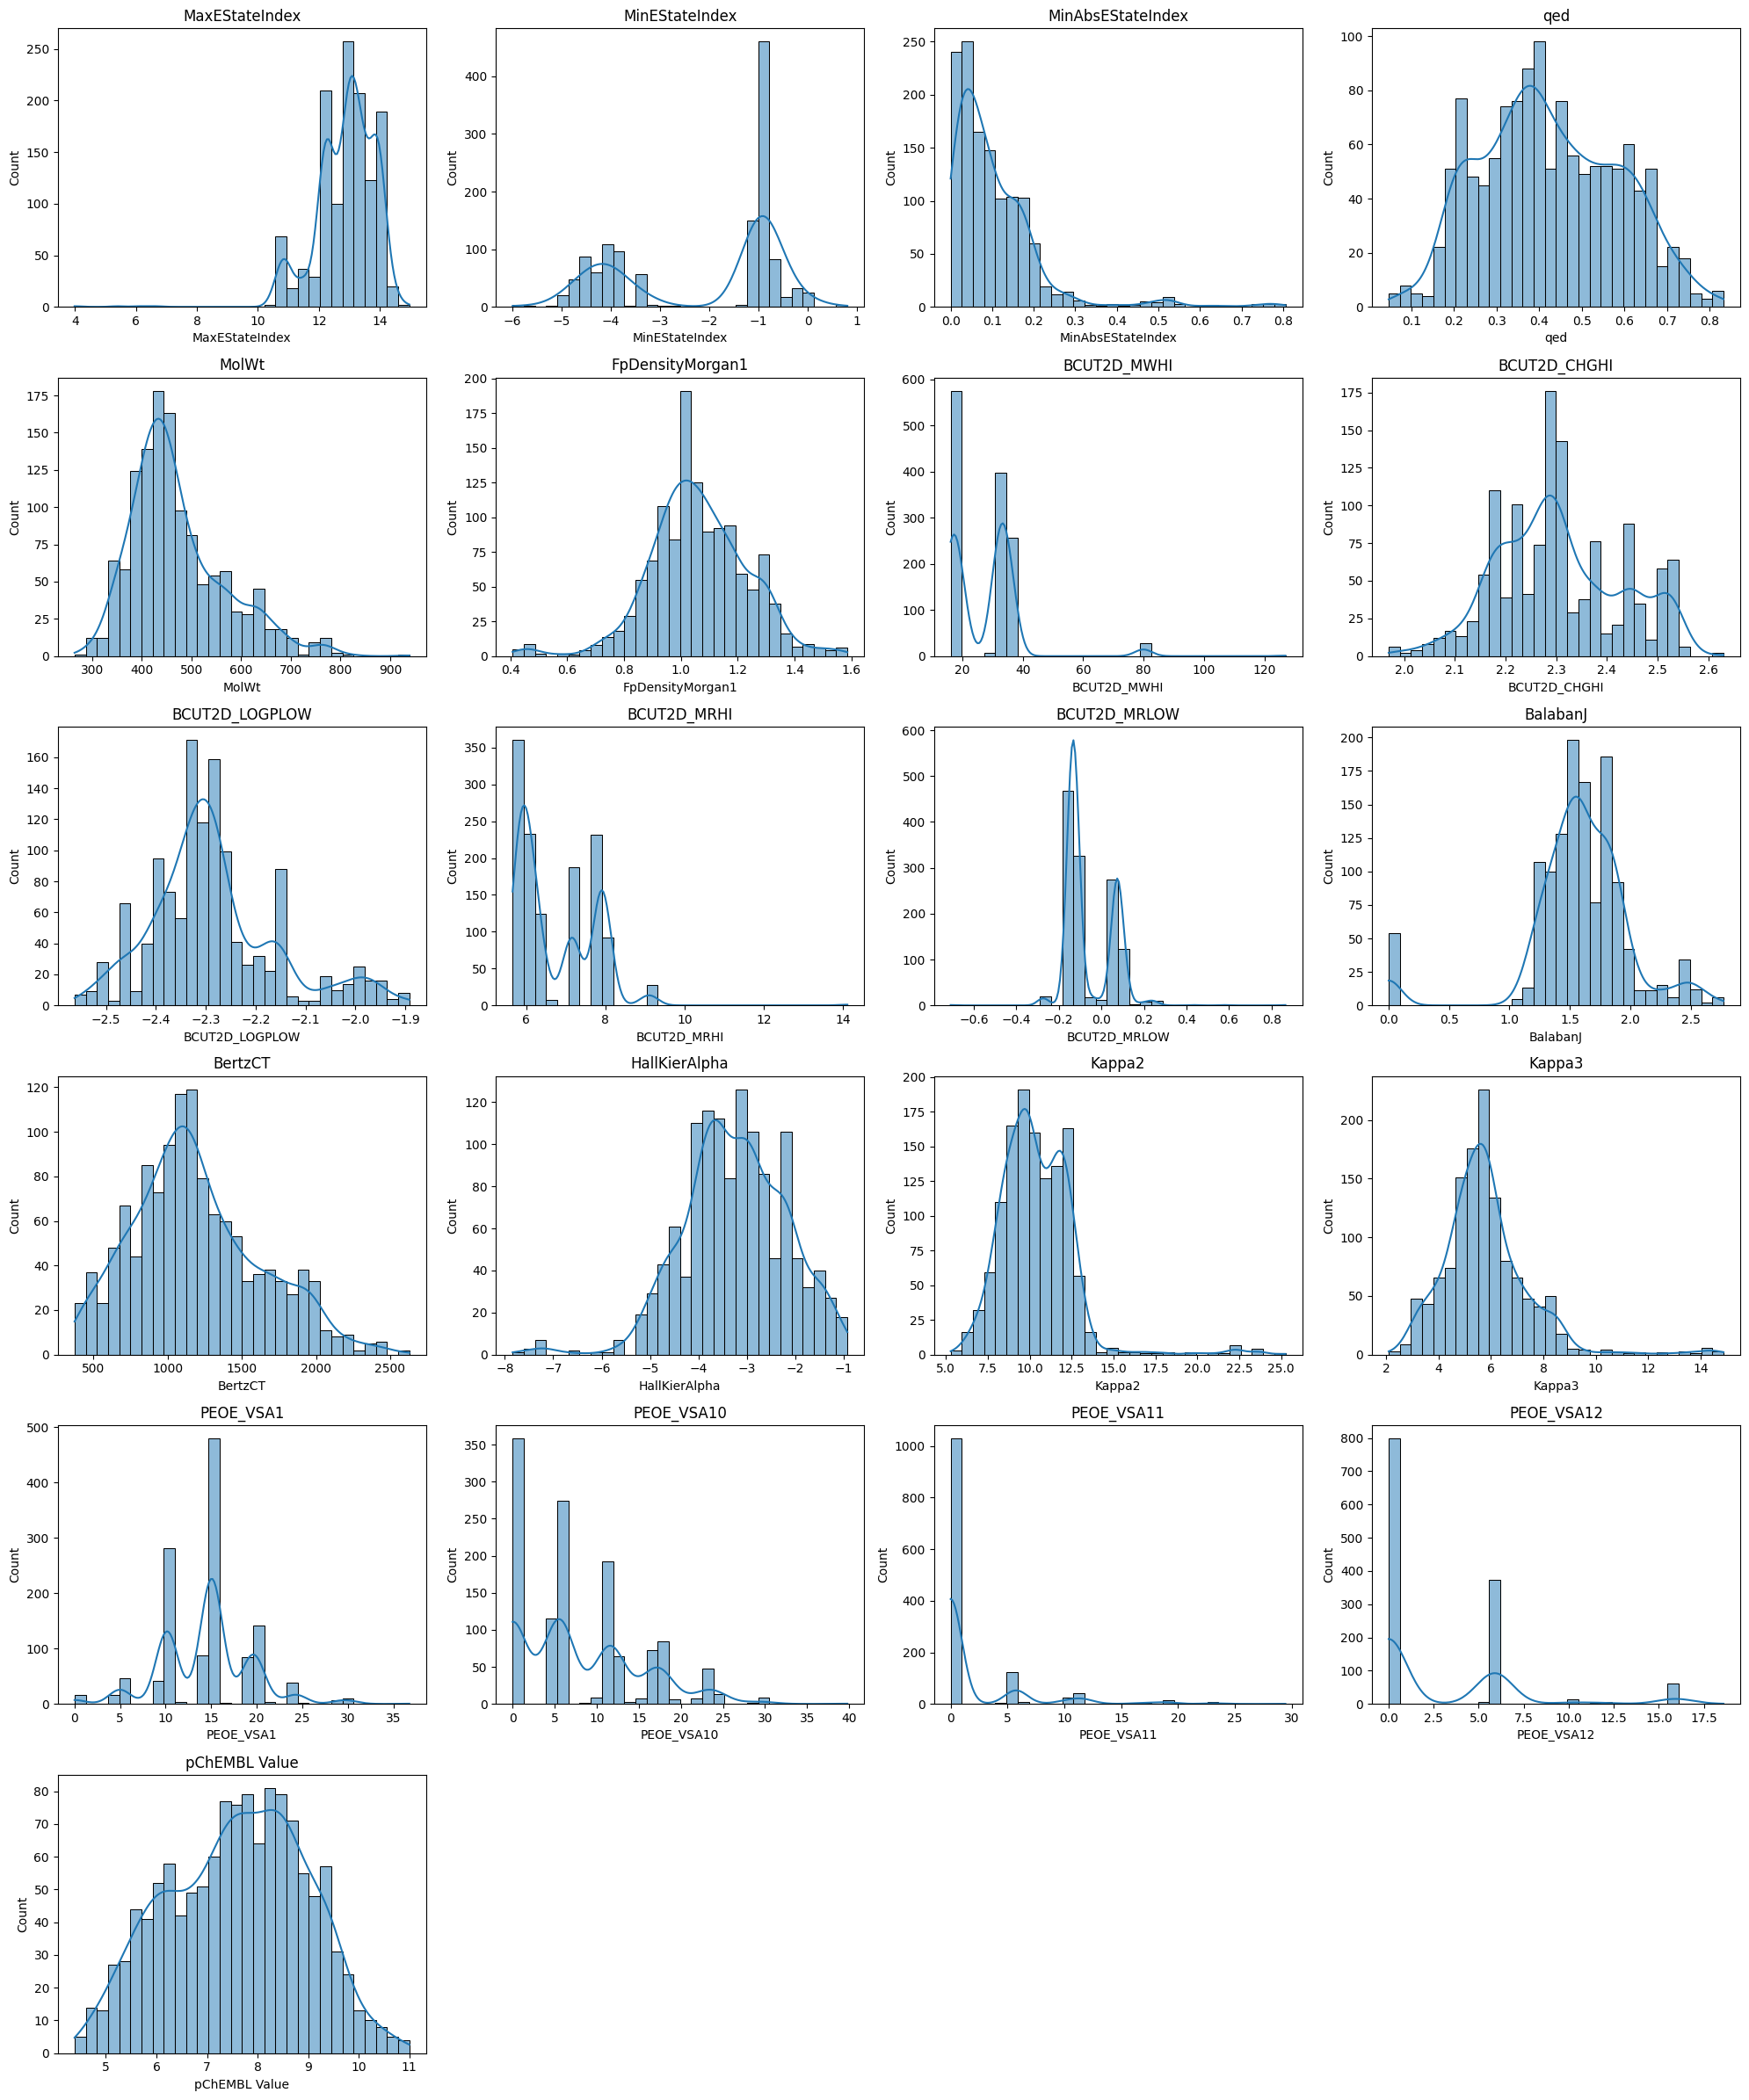

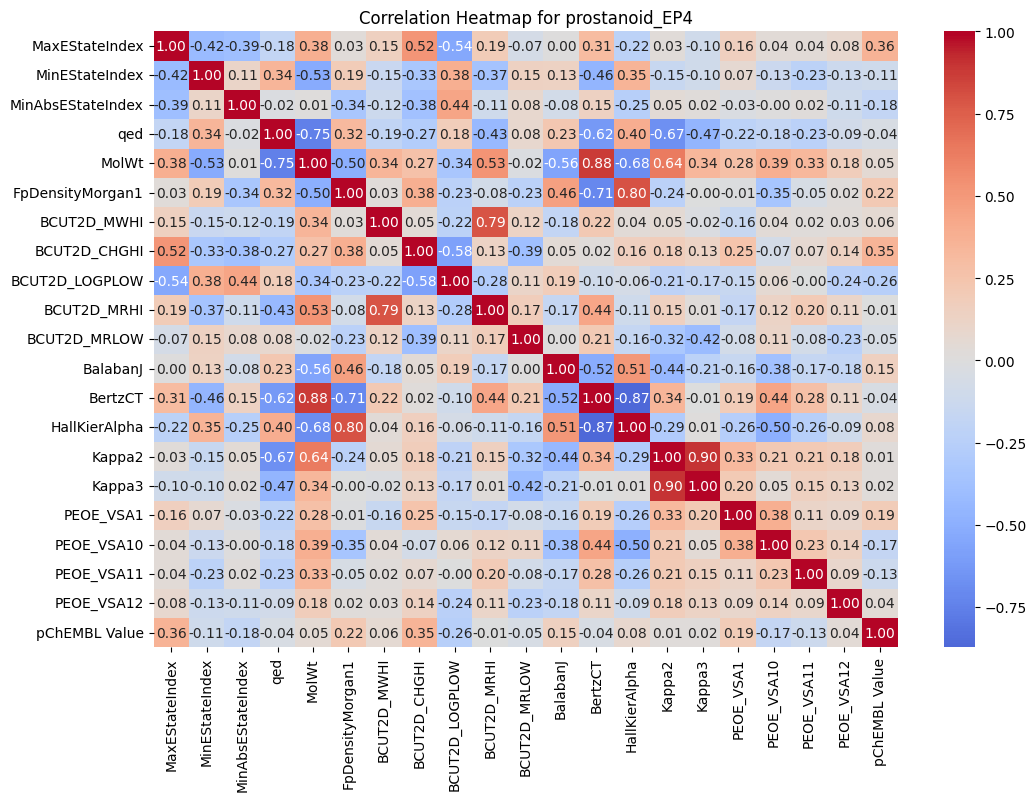


Applying Passive Learning...

Training Random Forest on prostanoid_EP4 dataset...

Baseline evaluation for Random Forest on prostanoid_EP4 dataset:
Baseline MAE: 1.0448
Baseline MSE: 1.6048
Baseline RMSE: 1.2668
Baseline R²: -0.0000

Random Forest Results on prostanoid_EP4 dataset:
  MAE: 0.7506
  MSE: 0.9345
  RMSE: 0.9667
  R² Score: 0.4177

Predictions for Terpenes dataset using Random Forest Passive Learning trained on prostanoid_EP4:
                   Name  Prediction
0       Alpha Bisabolol    5.716726
1               Cedrene    6.404691
2    Alpha Phellandrene    6.302558
3          Alpha Pinene    6.246266
4       Alpha Terpineol    5.991999
5    Beta Caryophyllene    6.234816
6           Beta Pinene    6.246266
7               Borneol    6.017899
8              Camphene    6.464303
9               Camphor    6.443815
10  Caryophyllene Oxide    6.070399
11               Citral    5.463300
12          Citronellol    5.641933
13       Delta 3 Carene    6.324355
14           D-L

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Baseline evaluation for XGBoost on prostanoid_EP4 dataset:
Baseline MAE: 1.0448
Baseline MSE: 1.6048
Baseline RMSE: 1.2668
Baseline R²: -0.0000

XGBoost Results on prostanoid_EP4 dataset:
  MAE: 0.7991
  MSE: 1.0831
  RMSE: 1.0407
  R² Score: 0.3251

Predictions for Terpenes dataset using XGBoost Passive Learning trained on prostanoid_EP4:
                   Name  Prediction
0       Alpha Bisabolol    5.372075
1               Cedrene    5.177320
2    Alpha Phellandrene    5.237541
3          Alpha Pinene    5.961258
4       Alpha Terpineol    6.366461
5    Beta Caryophyllene    5.474149
6           Beta Pinene    5.961258
7               Borneol    5.613105
8              Camphene    5.465209
9               Camphor    6.034346
10  Caryophyllene Oxide    5.698803
11               Citral    5.547458
12          Citronellol    5.217378
13       Delta 3 Carene    5.446721
14           D-Limonene    5.228969
15           Eucalyptol    5.451979
16              Eugenol    5.636143
17      A

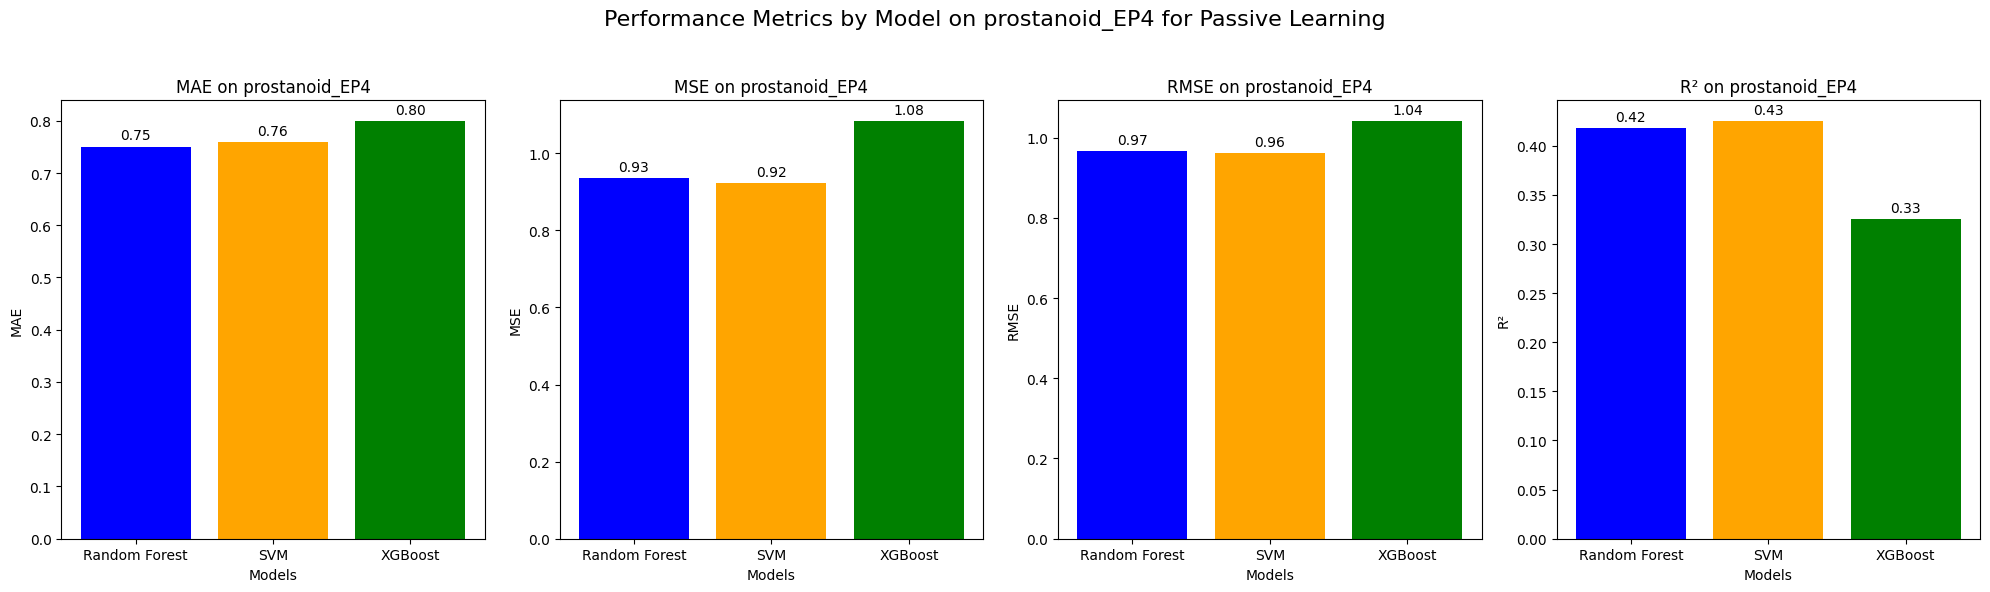


Passive Learning Results:
Random Forest:
  MAE: 0.7506
  MSE: 0.9345
  RMSE: 0.9667
  R²: 0.4177
  Baseline MAE: 1.0448
  Baseline MSE: 1.6048
  Baseline RMSE: 1.2668
  Baseline R²: -0.0000
SVM:
  MAE: 0.7591
  MSE: 0.9227
  RMSE: 0.9606
  R²: 0.4250
  Baseline MAE: 1.0448
  Baseline MSE: 1.6048
  Baseline RMSE: 1.2668
  Baseline R²: -0.0000
XGBoost:
  MAE: 0.7991
  MSE: 1.0831
  RMSE: 1.0407
  R²: 0.3251
  Baseline MAE: 1.0448
  Baseline MSE: 1.6048
  Baseline RMSE: 1.2668
  Baseline R²: -0.0000

Applying Active Learning with XGBoost...
Initial accuracy (R²) for prostanoid_EP4 with XGBoost: 0.1796


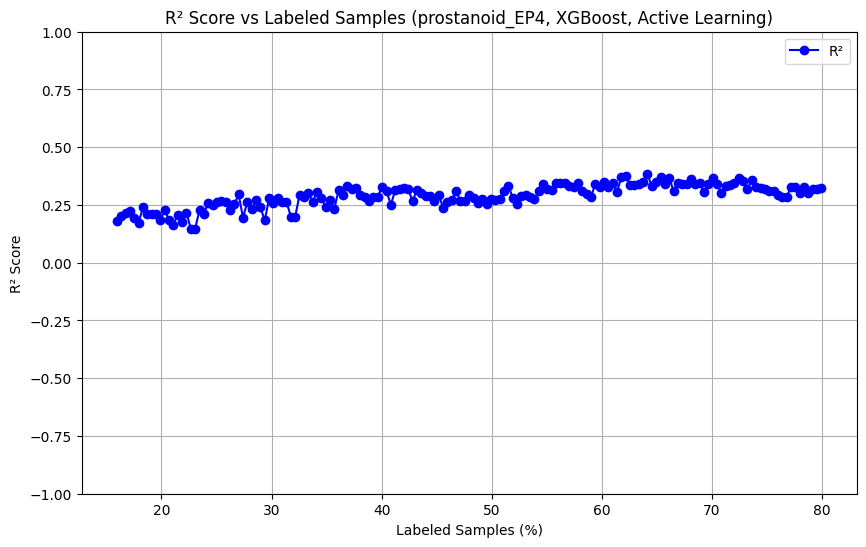

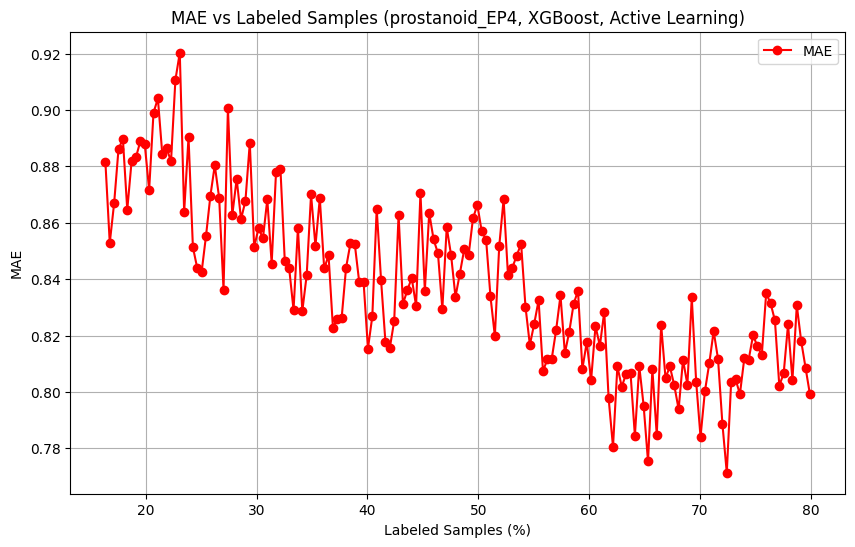

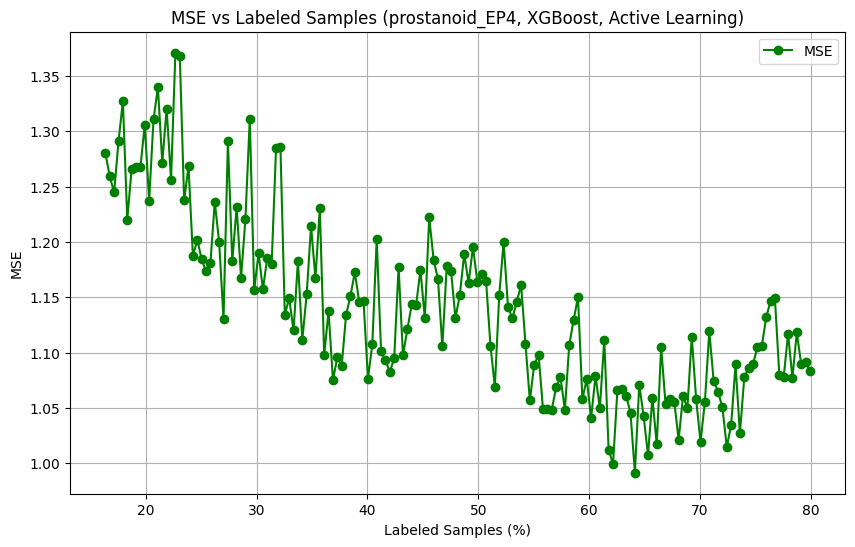

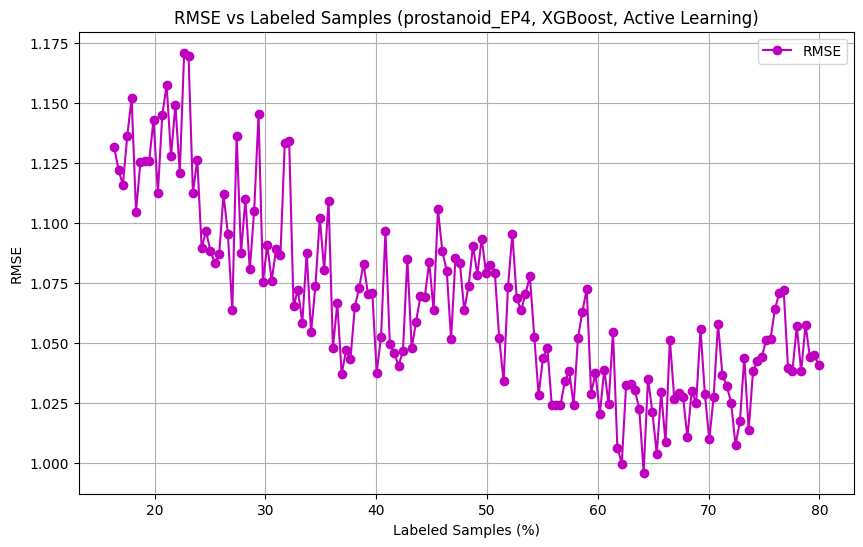

Final R²: 0.3251
Final MAE: 0.7991
Final MSE: 1.0831
Final RMSE: 1.0407

Predictions for Terpenes dataset using XGBoost Active Learning trained on prostanoid_EP4:
                   Name  Prediction
0       Alpha Bisabolol    5.372075
1               Cedrene    5.177320
2    Alpha Phellandrene    5.237541
3          Alpha Pinene    5.961258
4       Alpha Terpineol    6.366461
5    Beta Caryophyllene    5.474149
6           Beta Pinene    5.961258
7               Borneol    5.613105
8              Camphene    5.465209
9               Camphor    6.034346
10  Caryophyllene Oxide    5.698803
11               Citral    5.547458
12          Citronellol    5.217378
13       Delta 3 Carene    5.446721
14           D-Limonene    5.228969
15           Eucalyptol    5.451979
16              Eugenol    5.636143
17      Alpha Farnesene    5.850368
18       Bata Farnesene    5.841062
19              Fenchol    5.837402
20      Gamma Terpinene    5.248316
21             Geraniol    5.260077
22      G

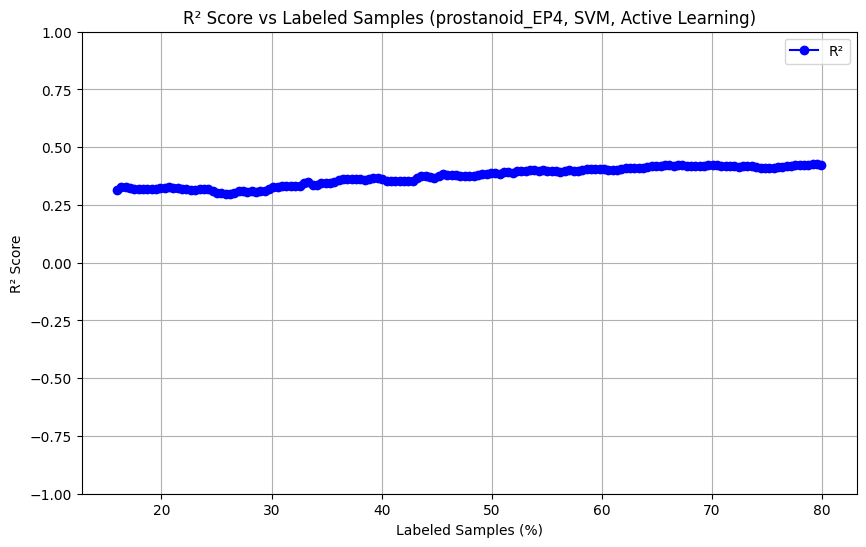

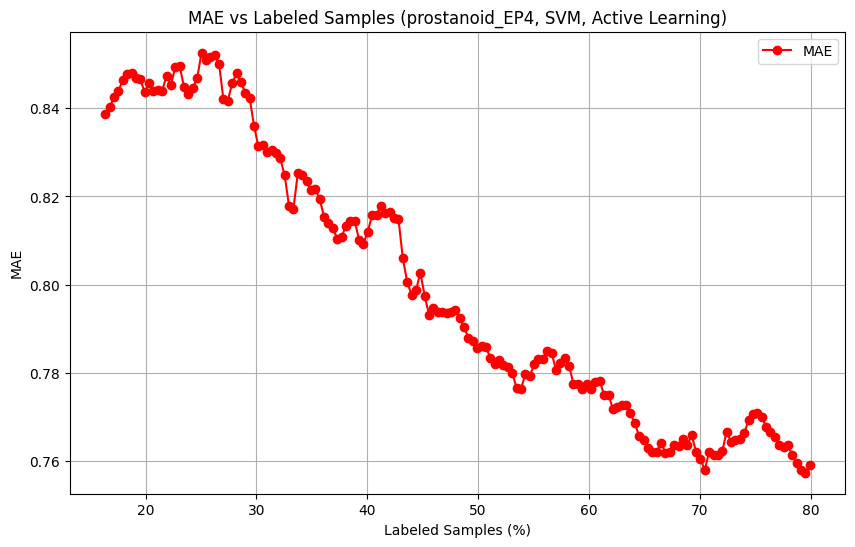

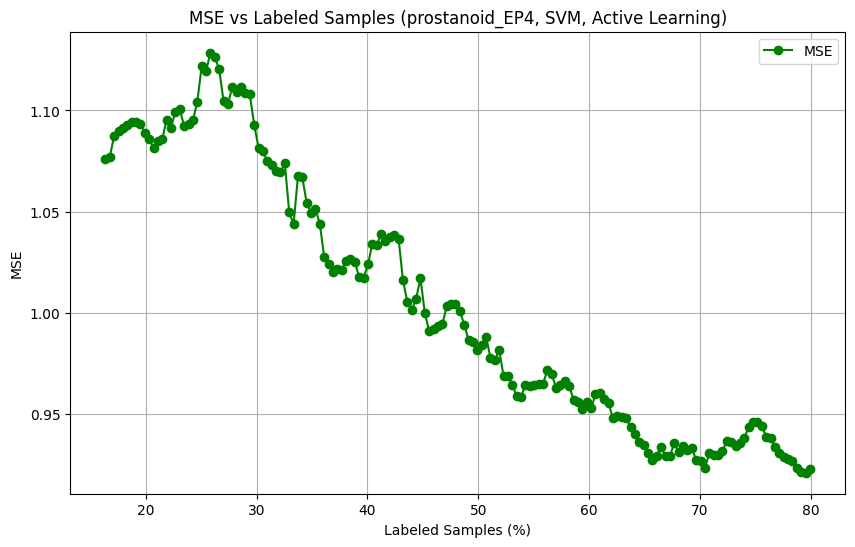

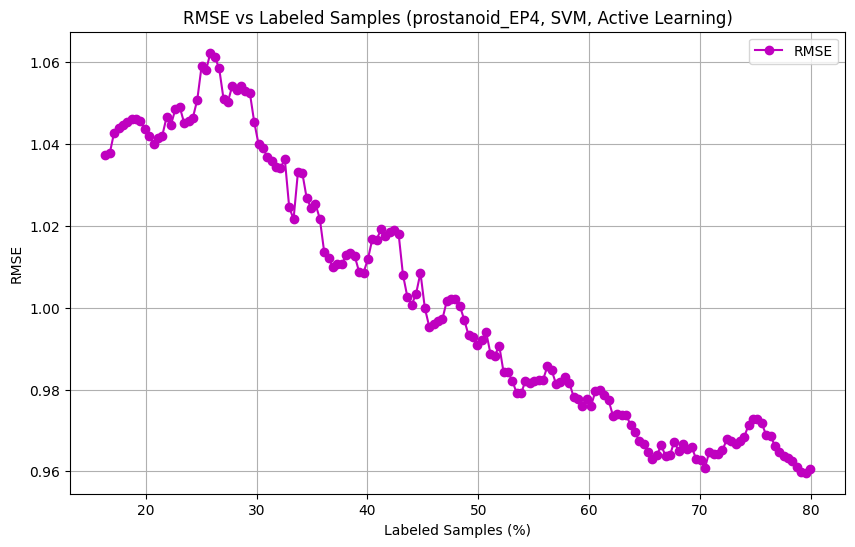

Final R²: 0.4250
Final MAE: 0.7591
Final MSE: 0.9227
Final RMSE: 0.9606

Predictions for Terpenes dataset using SVM Active Learning trained on prostanoid_EP4:
                   Name  Prediction
0       Alpha Bisabolol    6.356313
1               Cedrene    6.224316
2    Alpha Phellandrene    6.225179
3          Alpha Pinene    6.231222
4       Alpha Terpineol    6.123352
5    Beta Caryophyllene    6.174510
6           Beta Pinene    6.216897
7               Borneol    6.189137
8              Camphene    6.209277
9               Camphor    6.294838
10  Caryophyllene Oxide    6.128579
11               Citral    6.119650
12          Citronellol    6.173192
13       Delta 3 Carene    6.237248
14           D-Limonene    6.220572
15           Eucalyptol    6.162223
16              Eugenol    6.148915
17      Alpha Farnesene    6.229113
18       Bata Farnesene    6.224458
19              Fenchol    6.205079
20      Gamma Terpinene    6.215772
21             Geraniol    6.169923
22      Geran

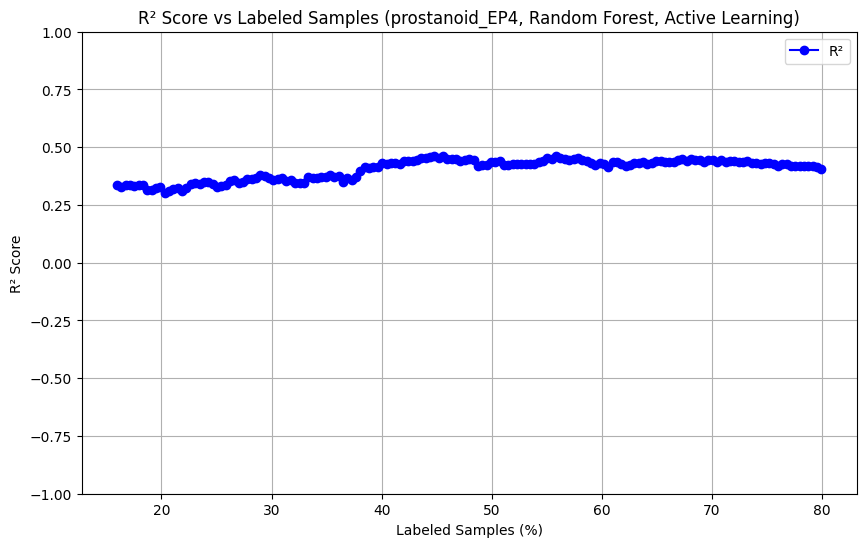

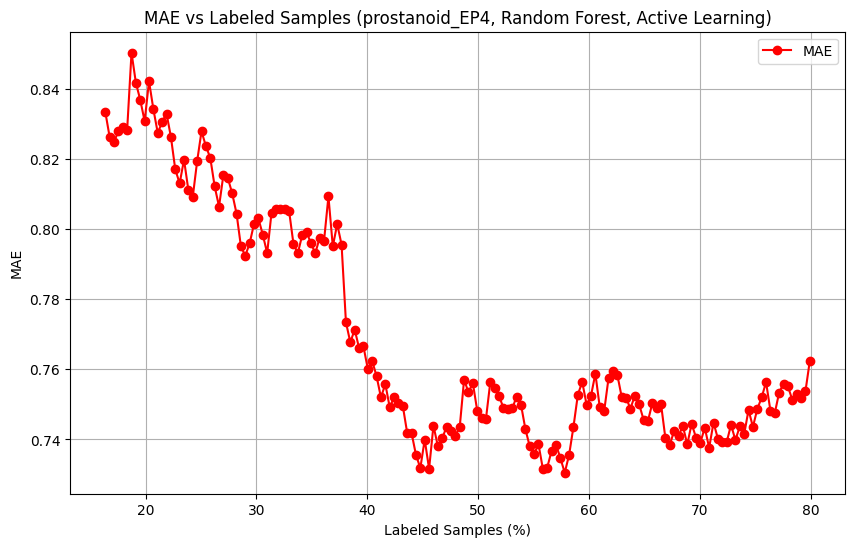

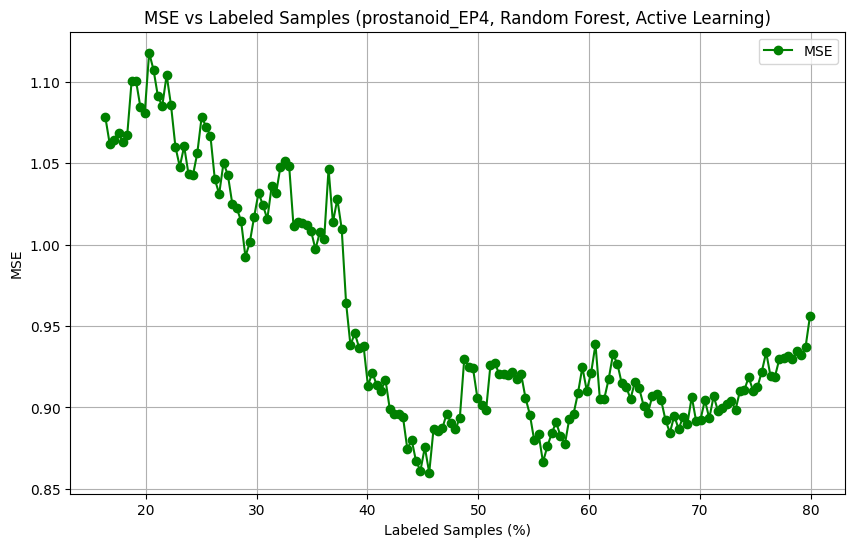

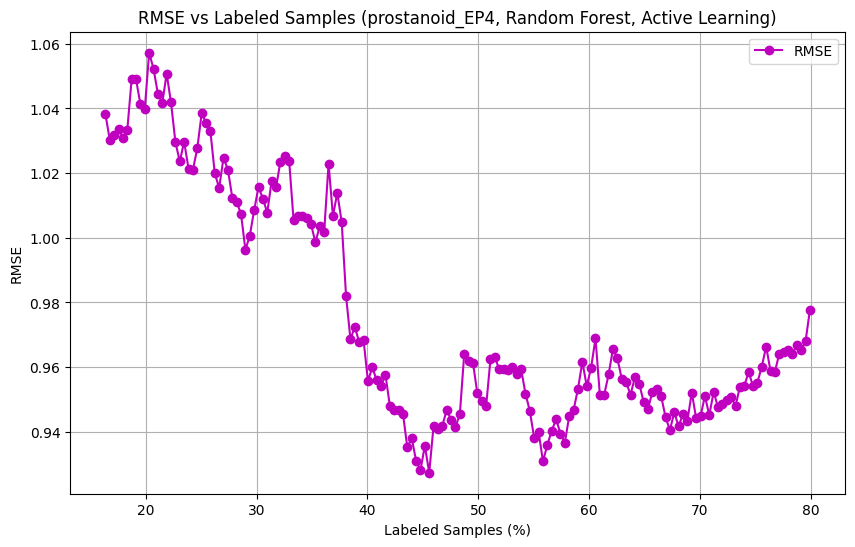

Final R²: 0.4043
Final MAE: 0.7624
Final MSE: 0.9559
Final RMSE: 0.9777

Predictions for Terpenes dataset using Random Forest Active Learning trained on prostanoid_EP4:
                   Name  Prediction
0       Alpha Bisabolol    5.897350
1               Cedrene    6.291150
2    Alpha Phellandrene    6.116435
3          Alpha Pinene    6.381642
4       Alpha Terpineol    6.145500
5    Beta Caryophyllene    6.365242
6           Beta Pinene    6.381642
7               Borneol    6.227542
8              Camphene    6.338107
9               Camphor    6.212908
10  Caryophyllene Oxide    6.320242
11               Citral    5.463417
12          Citronellol    5.626958
13       Delta 3 Carene    6.253950
14           D-Limonene    6.138875
15           Eucalyptol    6.273642
16              Eugenol    5.893475
17      Alpha Farnesene    5.663508
18       Bata Farnesene    5.663708
19              Fenchol    6.238992
20      Gamma Terpinene    5.962675
21             Geraniol    5.595558
22 

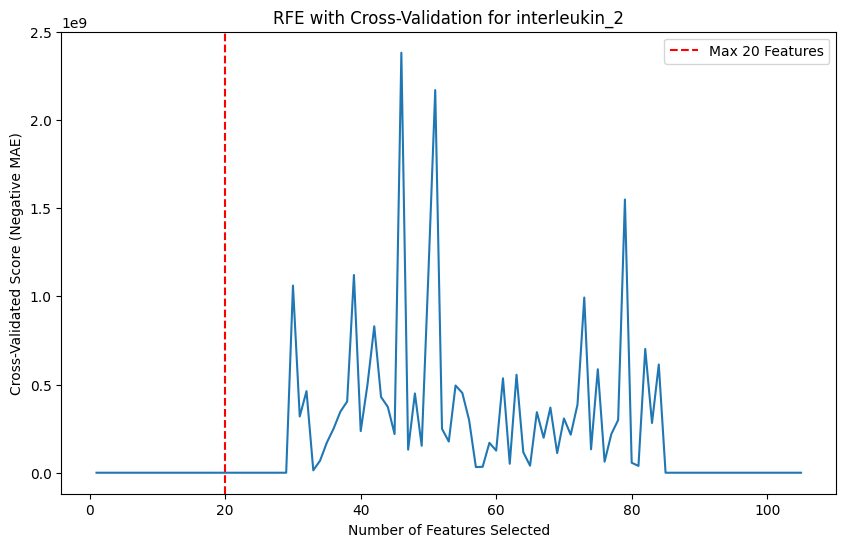

Performing EDA...

Basic Statistics:
       NumAliphaticHeterocycles  NumAromaticRings  NumSaturatedCarbocycles  \
count                 92.000000         92.000000                92.000000   
mean                   0.423913          3.184783                 0.206522   
std                    0.615437          0.678222                 0.545472   
min                    0.000000          0.000000                 0.000000   
25%                    0.000000          3.000000                 0.000000   
50%                    0.000000          3.000000                 0.000000   
75%                    1.000000          4.000000                 0.000000   
max                    3.000000          5.000000                 3.000000   

       NumSaturatedHeterocycles  RingCount  fr_Al_COO     fr_NH2  \
count                 92.000000  92.000000  92.000000  92.000000   
mean                   0.282609   3.945652   0.271739   0.141304   
std                    0.541185   1.009451   0.447294   

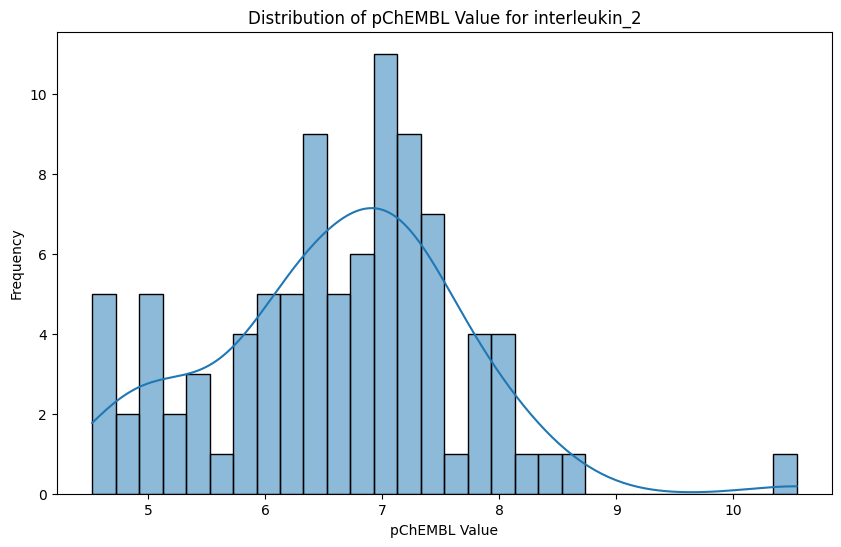

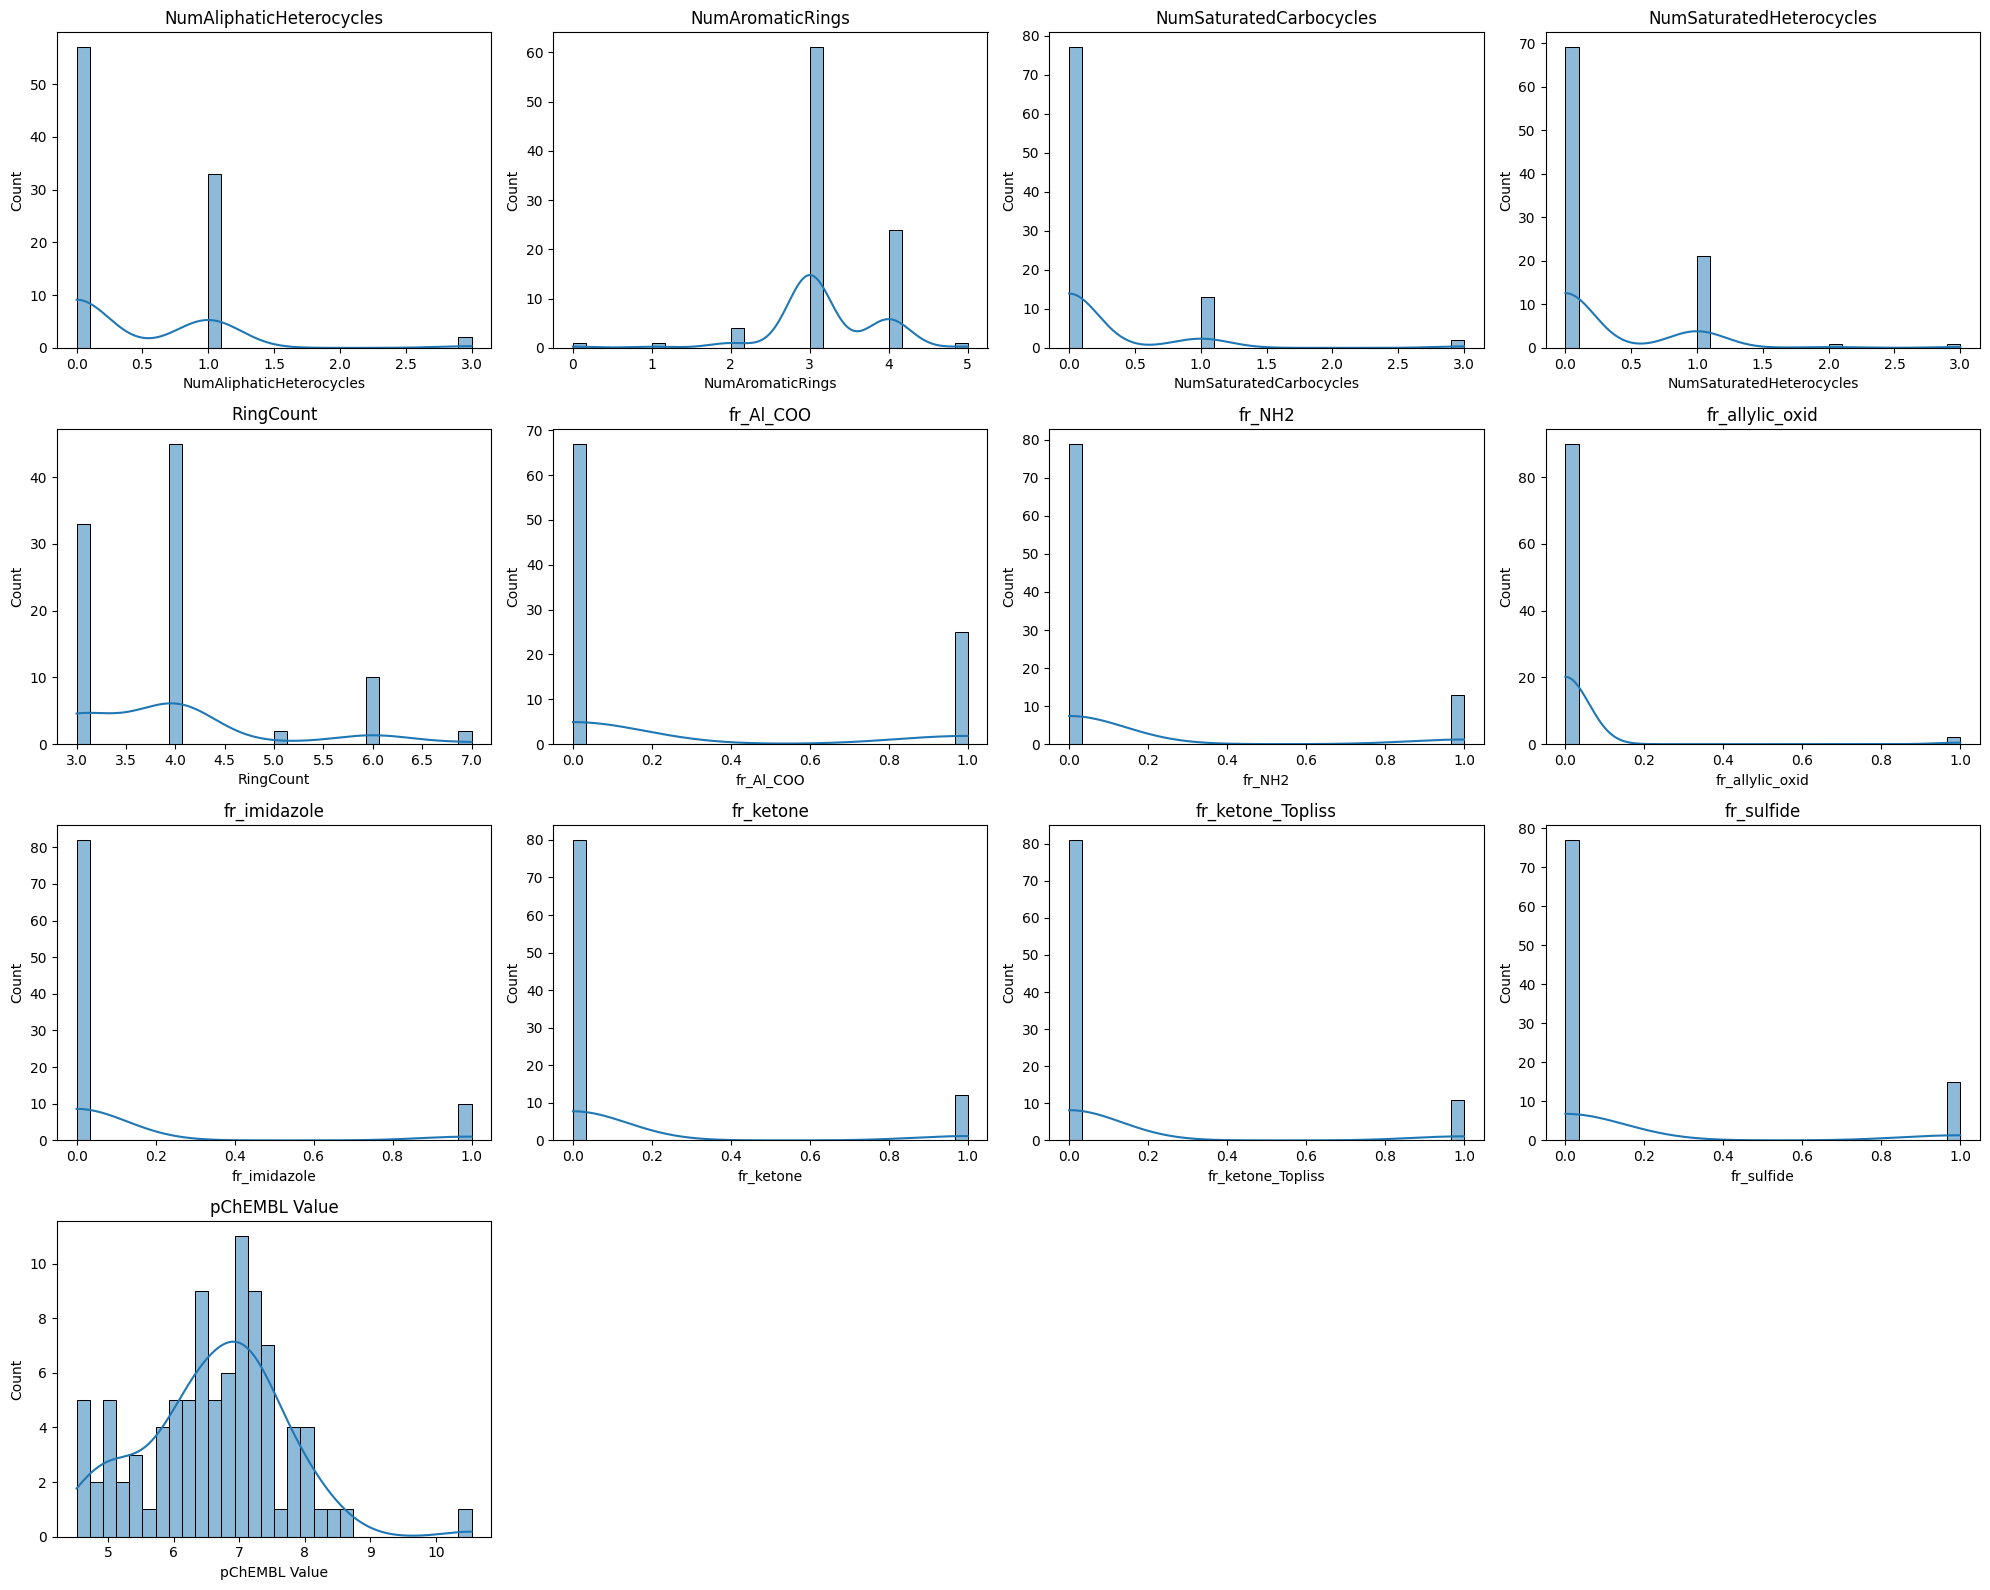

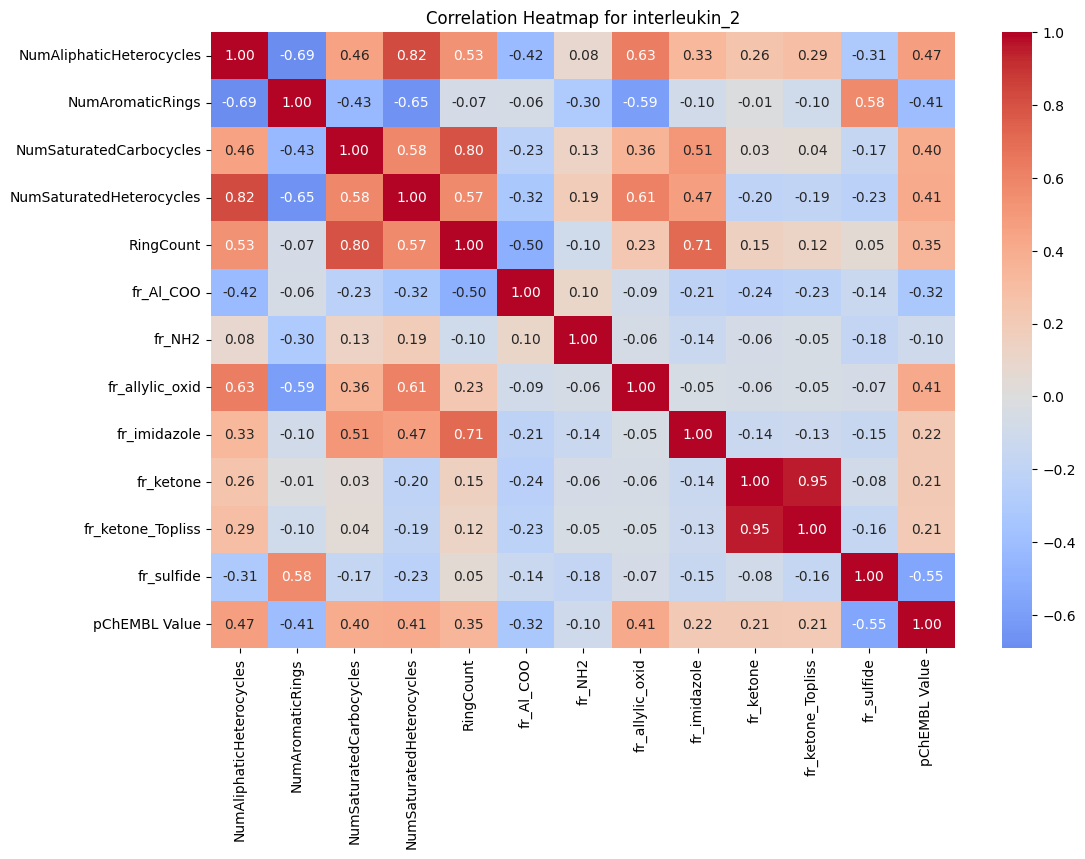


Applying Passive Learning...

Training Random Forest on interleukin_2 dataset...

Baseline evaluation for Random Forest on interleukin_2 dataset:
Baseline MAE: 0.6060
Baseline MSE: 0.6735
Baseline RMSE: 0.8207
Baseline R²: -0.0021

Random Forest Results on interleukin_2 dataset:
  MAE: 0.6468
  MSE: 0.7076
  RMSE: 0.8412
  R² Score: -0.0528

Predictions for Terpenes dataset using Random Forest Passive Learning trained on interleukin_2:


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


                   Name  Prediction
0       Alpha Bisabolol    7.785923
1               Cedrene    7.909187
2    Alpha Phellandrene    7.785923
3          Alpha Pinene    7.850687
4       Alpha Terpineol    7.785923
5    Beta Caryophyllene    7.850687
6           Beta Pinene    8.022287
7               Borneol    7.409670
8              Camphene    7.909187
9               Camphor    7.422203
10  Caryophyllene Oxide    7.654647
11               Citral    7.785923
12          Citronellol    7.785923
13       Delta 3 Carene    7.850687
14           D-Limonene    7.785923
15           Eucalyptol    7.152214
16              Eugenol    7.603423
17      Alpha Farnesene    7.785923
18       Bata Farnesene    7.785923
19              Fenchol    7.409670
20      Gamma Terpinene    7.785923
21             Geraniol    7.785923
22      Geranyl Acetate    7.785923
23             Humulene    7.785923
24           Isoborneol    7.409670
25             Linalool    7.785923
26              Menthol    7

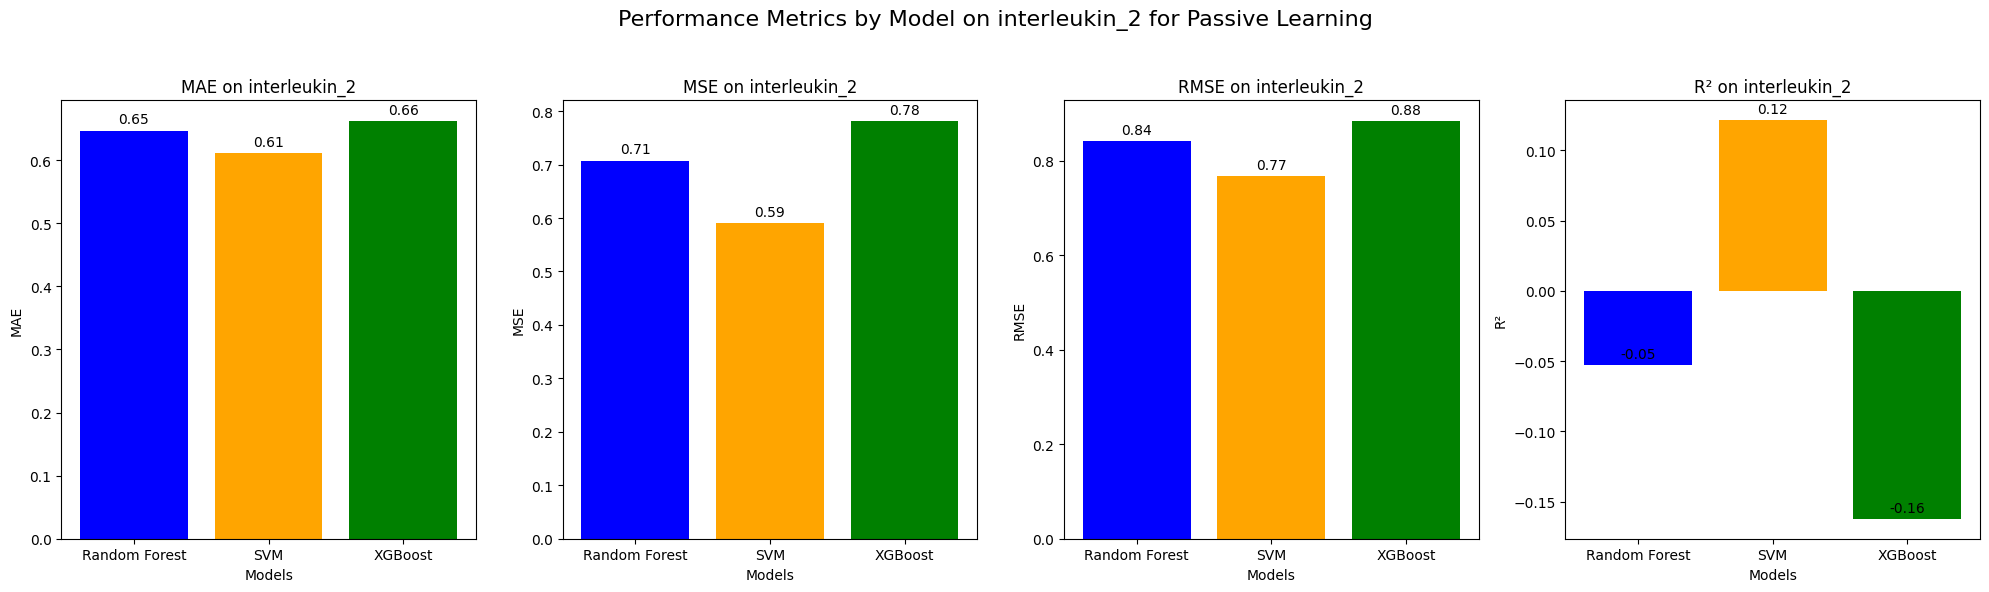


Passive Learning Results:
Random Forest:
  MAE: 0.6468
  MSE: 0.7076
  RMSE: 0.8412
  R²: -0.0528
  Baseline MAE: 0.6060
  Baseline MSE: 0.6735
  Baseline RMSE: 0.8207
  Baseline R²: -0.0021
SVM:
  MAE: 0.6111
  MSE: 0.5904
  RMSE: 0.7684
  R²: 0.1215
  Baseline MAE: 0.6060
  Baseline MSE: 0.6735
  Baseline RMSE: 0.8207
  Baseline R²: -0.0021
XGBoost:
  MAE: 0.6617
  MSE: 0.7811
  RMSE: 0.8838
  R²: -0.1622
  Baseline MAE: 0.6060
  Baseline MSE: 0.6735
  Baseline RMSE: 0.8207
  Baseline R²: -0.0021

Applying Active Learning with XGBoost...
Initial accuracy (R²) for interleukin_2 with XGBoost: 0.1756


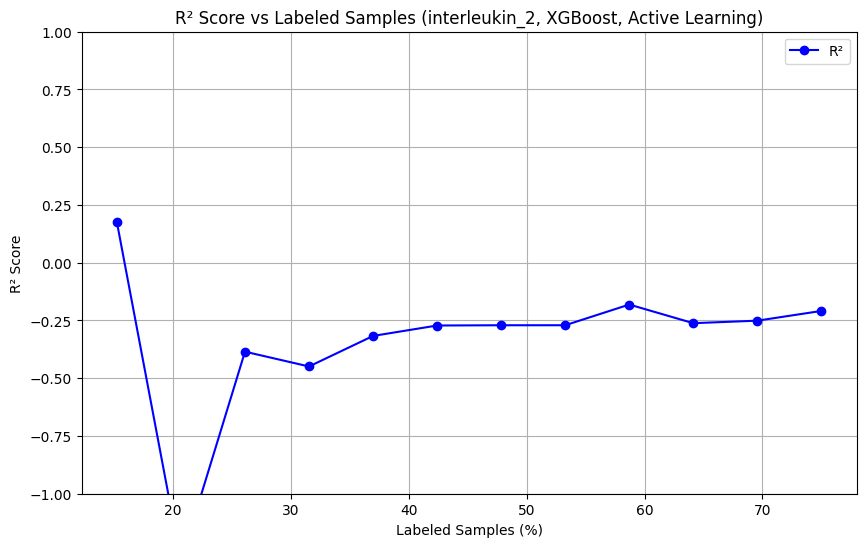

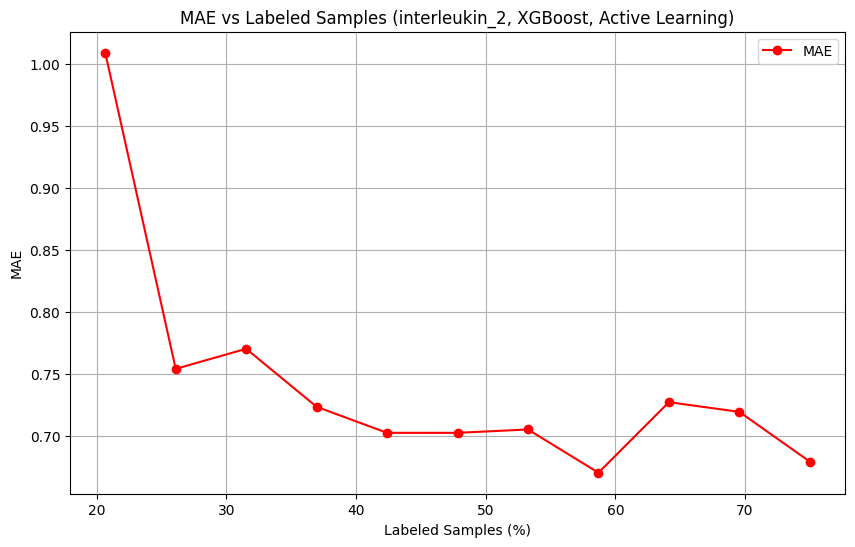

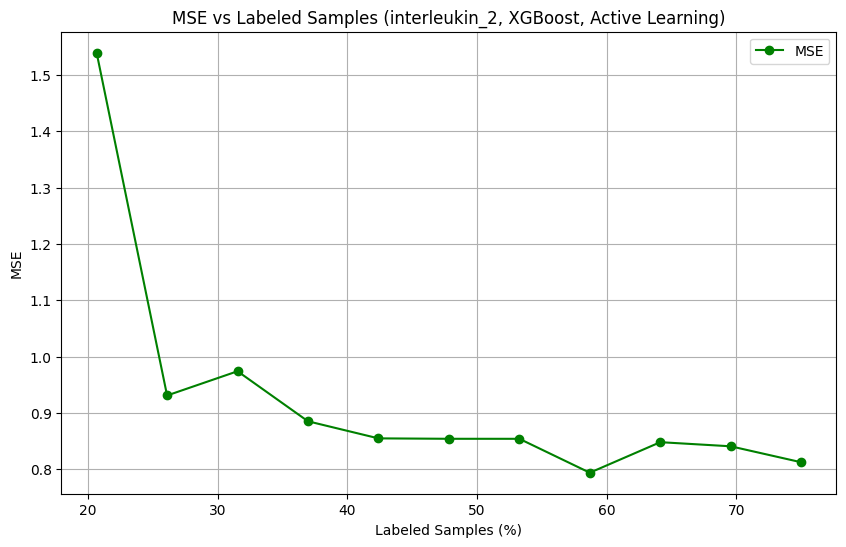

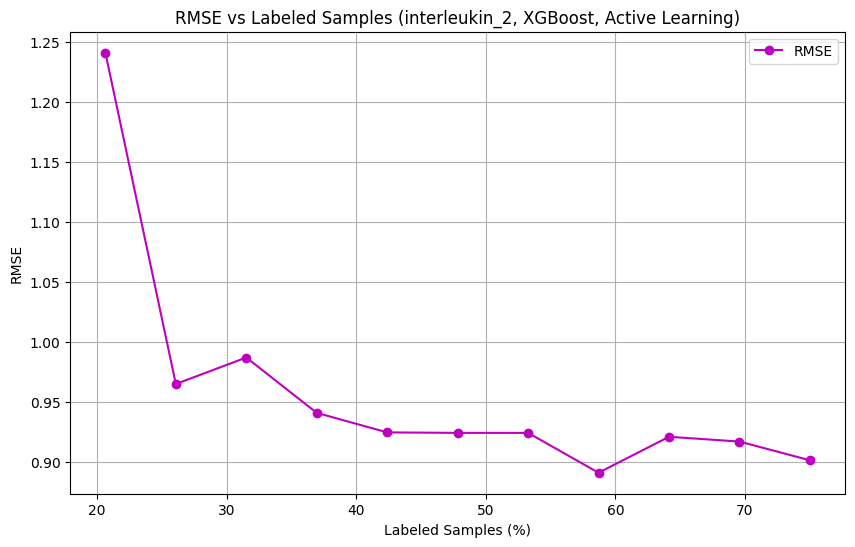

Final R²: -0.2087
Final MAE: 0.6794
Final MSE: 0.8123
Final RMSE: 0.9013

Predictions for Terpenes dataset using XGBoost Active Learning trained on interleukin_2:
                   Name  Prediction
0       Alpha Bisabolol    5.986013
1               Cedrene    7.579011
2    Alpha Phellandrene    5.986013
3          Alpha Pinene    7.579011
4       Alpha Terpineol    5.986013
5    Beta Caryophyllene    7.579011
6           Beta Pinene    7.579011
7               Borneol    7.579011
8              Camphene    7.579011
9               Camphor    7.577313
10  Caryophyllene Oxide    7.373480
11               Citral    5.986013
12          Citronellol    5.986013
13       Delta 3 Carene    7.579011
14           D-Limonene    5.986013
15           Eucalyptol    7.373480
16              Eugenol    5.705273
17      Alpha Farnesene    5.986013
18       Bata Farnesene    5.986013
19              Fenchol    7.579011
20      Gamma Terpinene    5.986013
21             Geraniol    5.986013
22      G

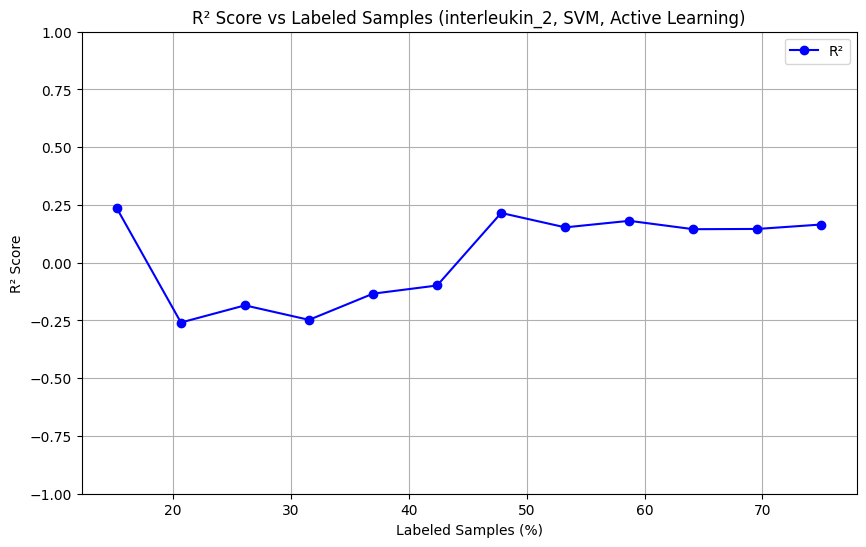

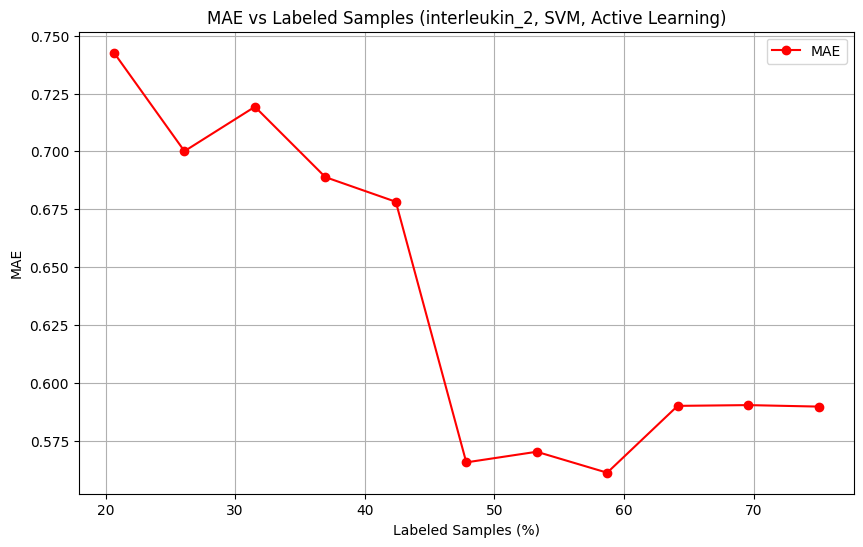

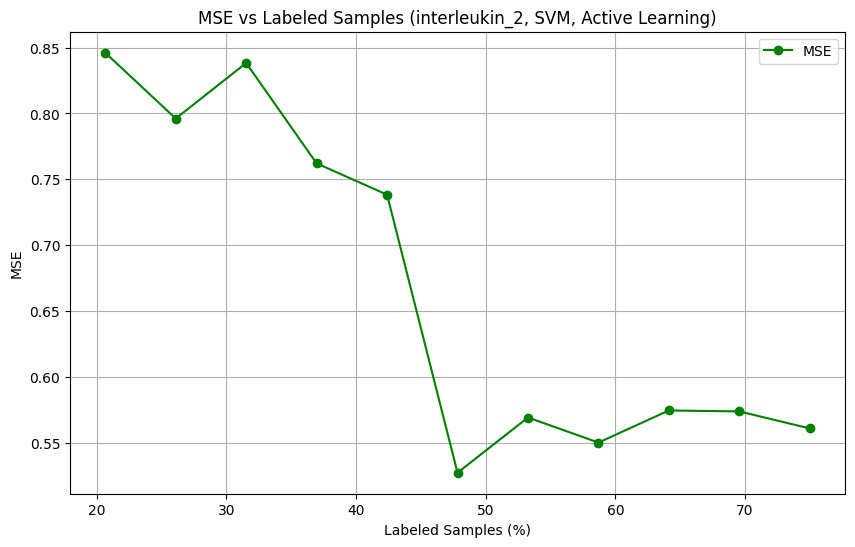

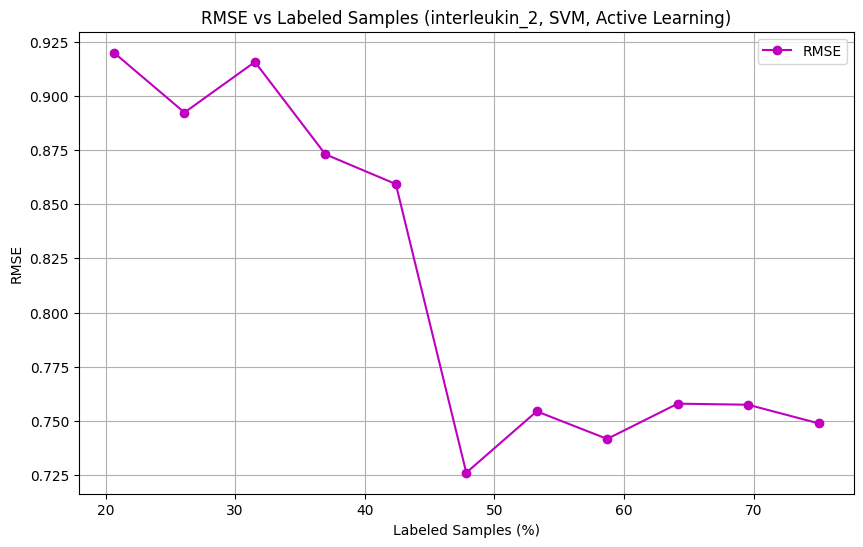

Final R²: 0.1654
Final MAE: 0.5897
Final MSE: 0.5609
Final RMSE: 0.7489

Predictions for Terpenes dataset using SVM Active Learning trained on interleukin_2:
                   Name  Prediction
0       Alpha Bisabolol    7.190695
1               Cedrene    7.191796
2    Alpha Phellandrene    7.190695
3          Alpha Pinene    7.192639
4       Alpha Terpineol    7.191990
5    Beta Caryophyllene    7.190695
6           Beta Pinene    7.201107
7               Borneol    7.193562
8              Camphene    7.206721
9               Camphor    7.200224
10  Caryophyllene Oxide    7.332096
11               Citral    7.190695
12          Citronellol    7.191460
13       Delta 3 Carene    7.192221
14           D-Limonene    7.190695
15           Eucalyptol    7.151403
16              Eugenol    7.222686
17      Alpha Farnesene    7.190695
18       Bata Farnesene    7.190695
19              Fenchol    7.193562
20      Gamma Terpinene    7.190695
21             Geraniol    7.190695
22      Gerany

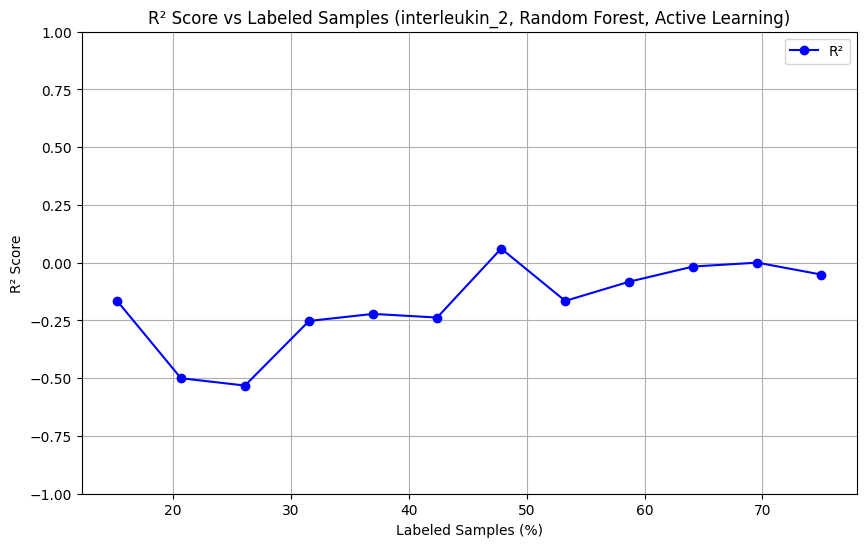

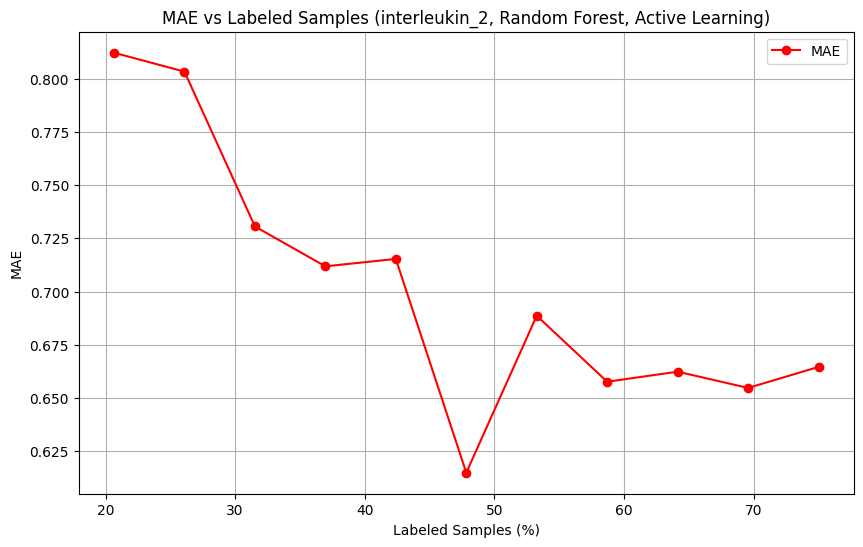

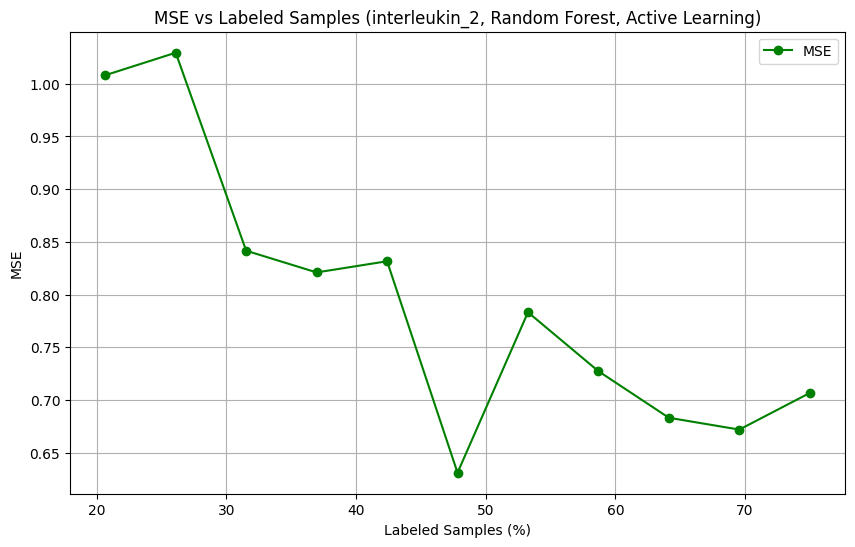

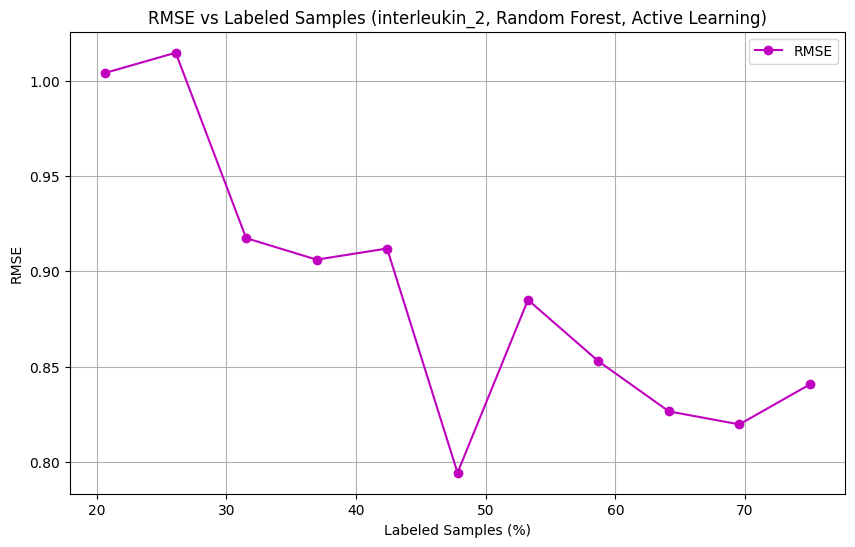

Final R²: -0.0514
Final MAE: 0.6646
Final MSE: 0.7066
Final RMSE: 0.8406

Predictions for Terpenes dataset using Random Forest Active Learning trained on interleukin_2:
                   Name  Prediction
0       Alpha Bisabolol    7.844822
1               Cedrene    8.029236
2    Alpha Phellandrene    7.844822
3          Alpha Pinene    7.985356
4       Alpha Terpineol    7.844822
5    Beta Caryophyllene    7.985356
6           Beta Pinene    8.141296
7               Borneol    7.656191
8              Camphene    8.029236
9               Camphor    7.648082
10  Caryophyllene Oxide    7.787623
11               Citral    7.844822
12          Citronellol    7.844822
13       Delta 3 Carene    7.985356
14           D-Limonene    7.844822
15           Eucalyptol    7.480413
16              Eugenol    7.580942
17      Alpha Farnesene    7.844822
18       Bata Farnesene    7.844822
19              Fenchol    7.656191
20      Gamma Terpinene    7.844822
21             Geraniol    7.844822
22 

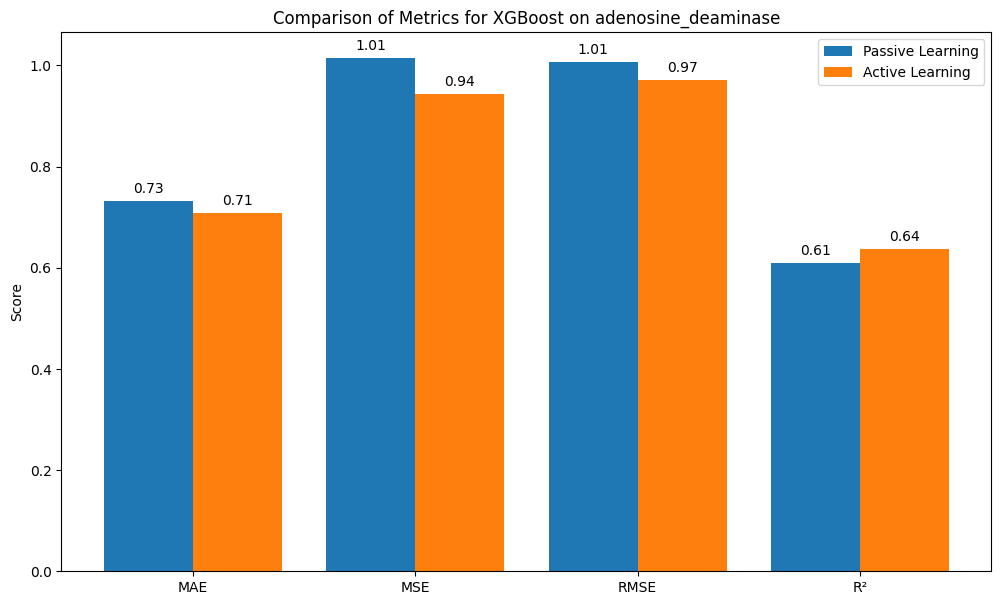

MAE: Active Learning performed better.
MSE: Active Learning performed better.
RMSE: Active Learning performed better.
R²: Active Learning performed better.

Comparing Passive and Active Learning for SVM:


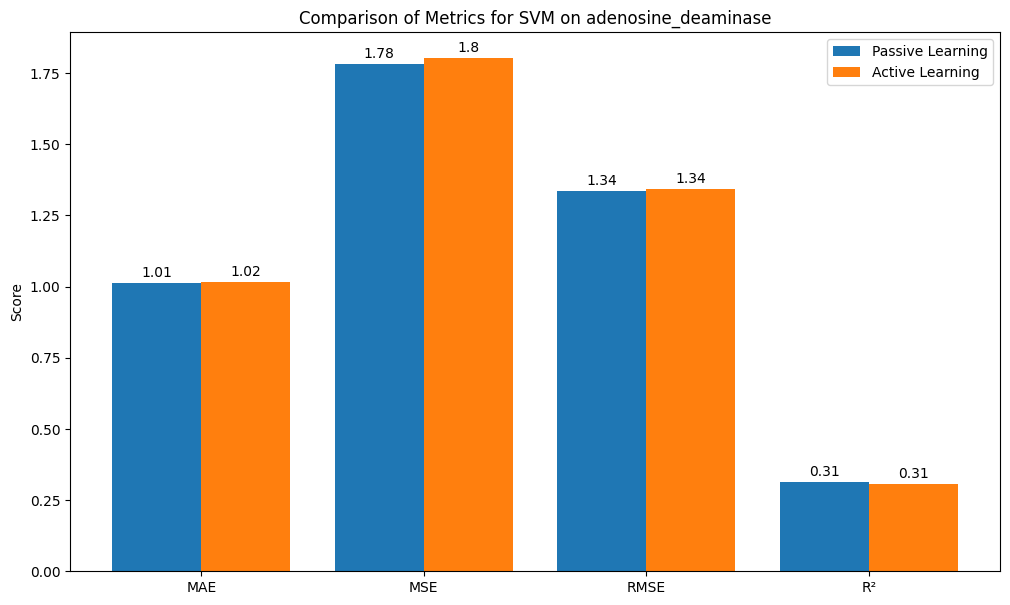

MAE: Passive Learning performed better.
MSE: Passive Learning performed better.
RMSE: Passive Learning performed better.
R²: Passive Learning performed better.

Comparing Passive and Active Learning for Random Forest:


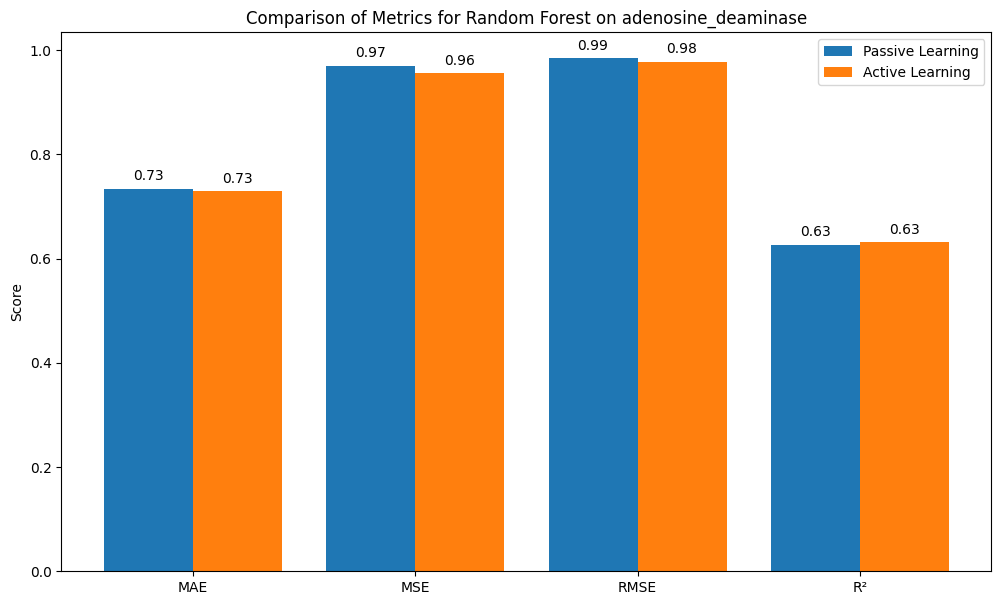

MAE: Active Learning performed better.
MSE: Active Learning performed better.
RMSE: Active Learning performed better.
R²: Active Learning performed better.

Comparing Passive and Active Learning for dataset: prostanoid_EP4

Comparing Passive and Active Learning for XGBoost:


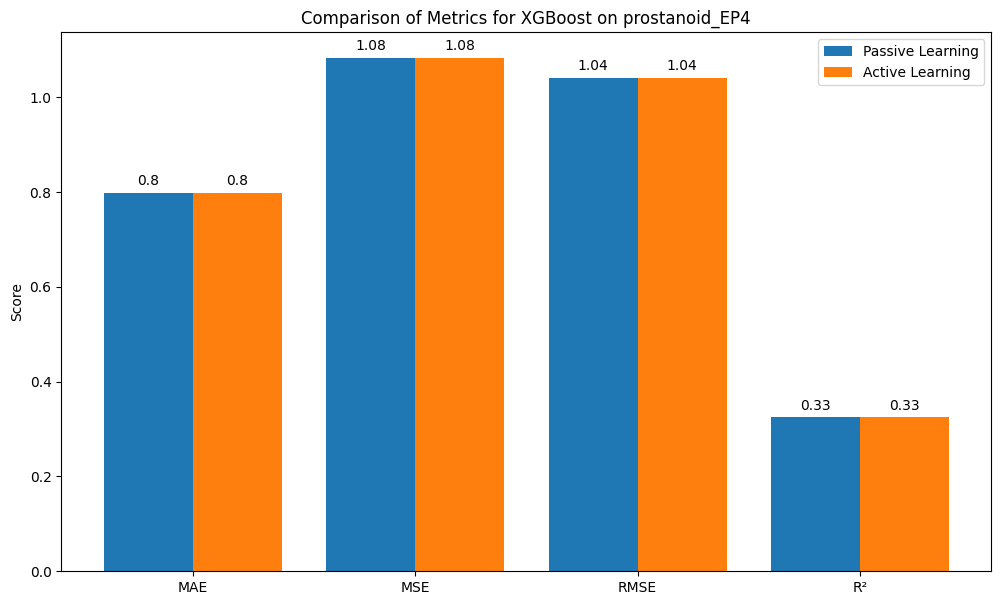

MAE: Passive Learning performed better.
MSE: Passive Learning performed better.
RMSE: Passive Learning performed better.
R²: Passive Learning performed better.

Comparing Passive and Active Learning for SVM:


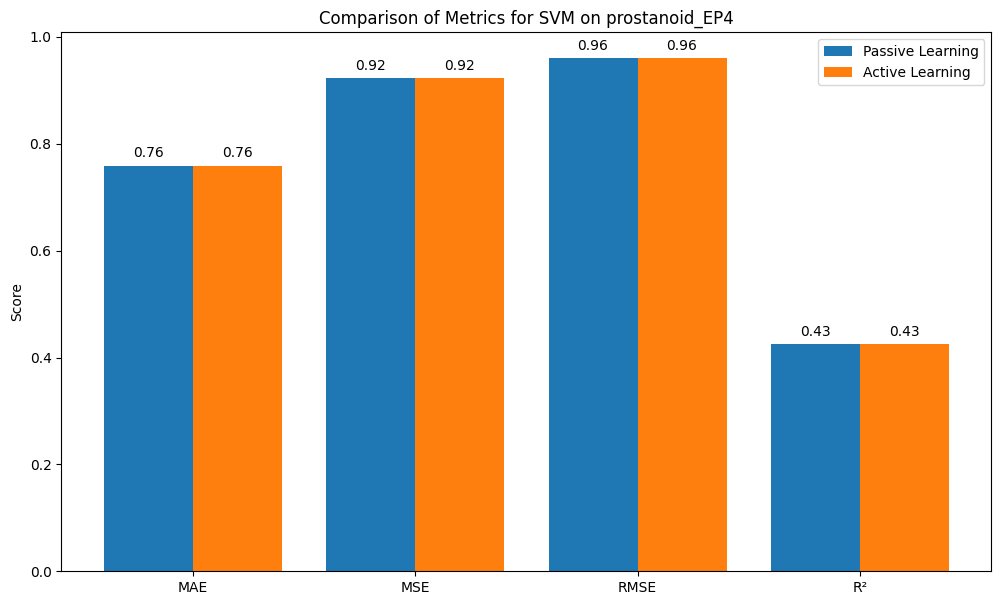

MAE: Active Learning performed better.
MSE: Active Learning performed better.
RMSE: Active Learning performed better.
R²: Active Learning performed better.

Comparing Passive and Active Learning for Random Forest:


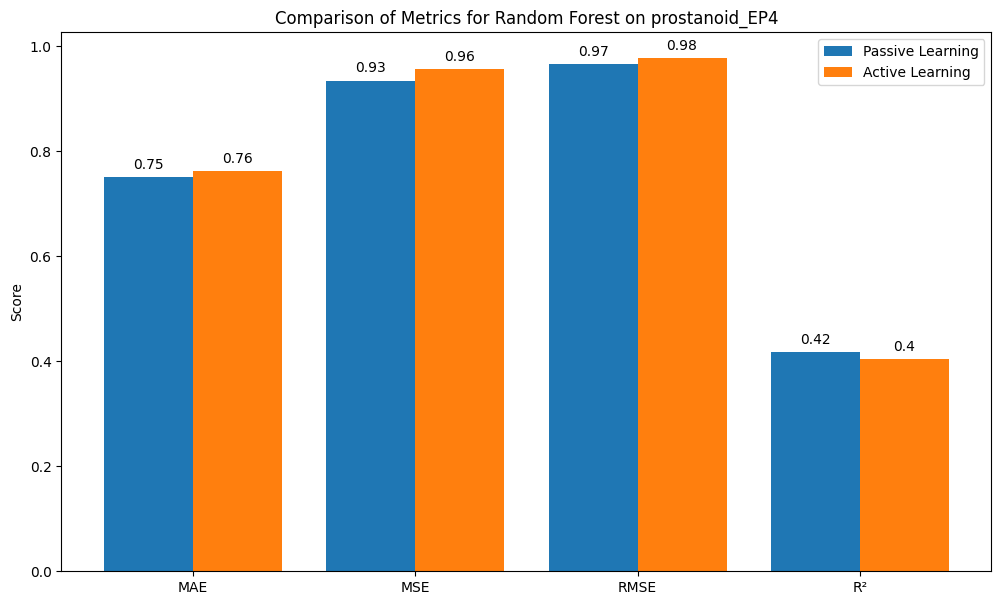

MAE: Passive Learning performed better.
MSE: Passive Learning performed better.
RMSE: Passive Learning performed better.
R²: Passive Learning performed better.

Comparing Passive and Active Learning for dataset: interleukin_2

Comparing Passive and Active Learning for XGBoost:


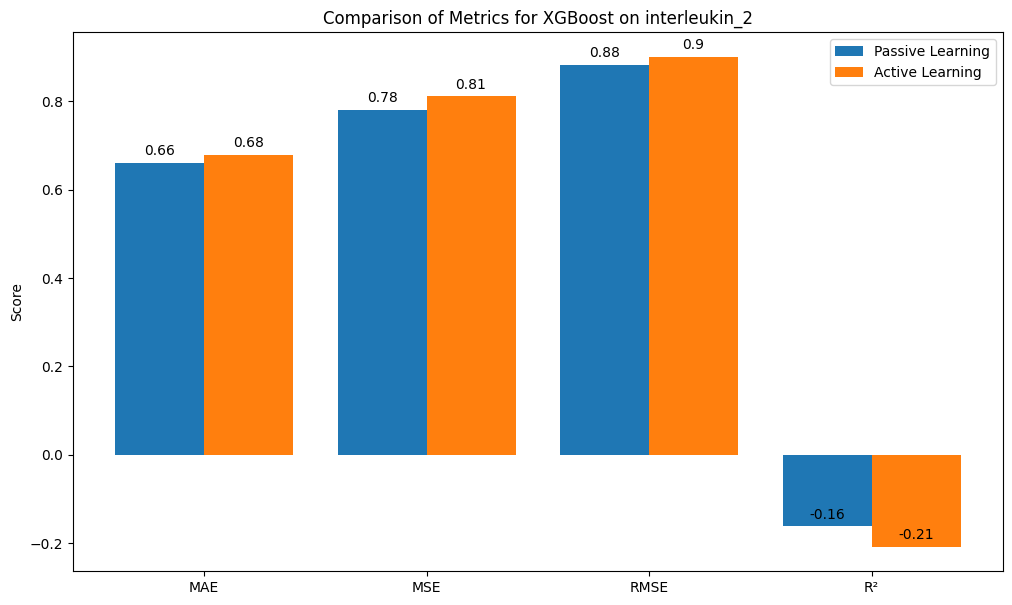

MAE: Passive Learning performed better.
MSE: Passive Learning performed better.
RMSE: Passive Learning performed better.
R²: Passive Learning performed better.

Comparing Passive and Active Learning for SVM:


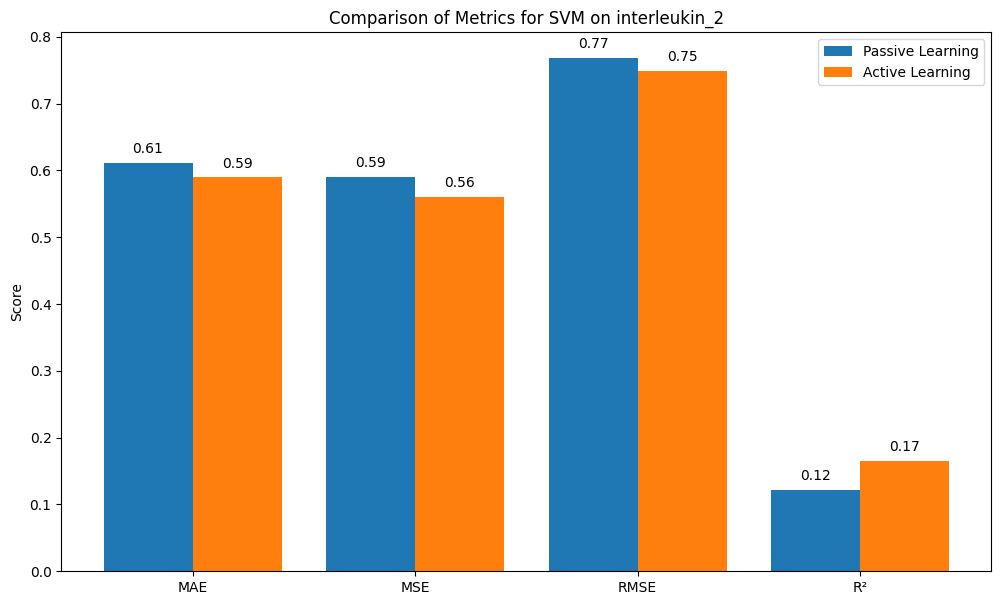

MAE: Active Learning performed better.
MSE: Active Learning performed better.
RMSE: Active Learning performed better.
R²: Active Learning performed better.

Comparing Passive and Active Learning for Random Forest:


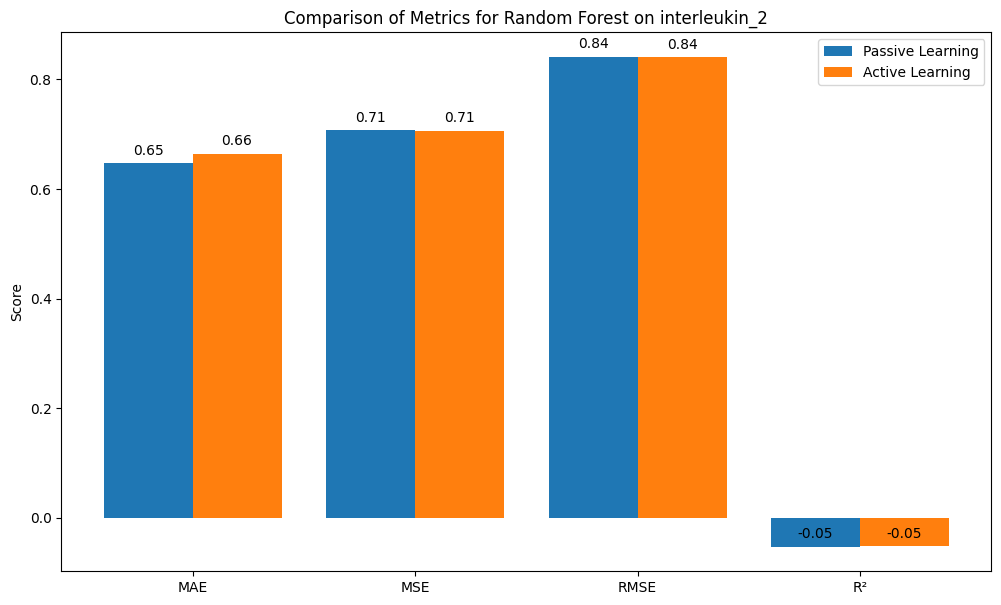

MAE: Passive Learning performed better.
MSE: Active Learning performed better.
RMSE: Active Learning performed better.
R²: Active Learning performed better.

Summary for adenosine_deaminase dataset:
  Best Model (Passive Learning): Random Forest with Aggregated Score = 2.0632
  Best Model (Active Learning): XGBoost with Aggregated Score = 1.9846
  Active Learning outperformed Passive Learning.

Summary for prostanoid_EP4 dataset:
  Best Model (Passive Learning): SVM with Aggregated Score = 2.2173
  Best Model (Active Learning): SVM with Aggregated Score = 2.2173
  Active Learning outperformed Passive Learning.

Summary for interleukin_2 dataset:
  Best Model (Passive Learning): SVM with Aggregated Score = 1.8484
  Best Model (Active Learning): SVM with Aggregated Score = 1.7341
  Active Learning outperformed Passive Learning.

Best Performing Models Across Datasets:

Dataset: adenosine_deaminase
  Best Passive Learning Model: Random Forest
  Best Active Learning Model: XGBoost
  Active

In [ ]:
# Call the functions and apply to the datasets
check_features_and_dimensions(file_paths)  # Check the dimensions and features of all datasets
comparison_results = {}  # Initialize a dictionary to store comparison results

# Processing Terpenes dataset
print("Processing Terpenes dataset:")  # Print message indicating the start of Terpenes dataset processing
terpenes_dataset_clean, terpenes_descriptor_names = load_terpenes_for_prediction(file_paths['terpenes'])  # Load and preprocess the Terpenes dataset

# Run models on all datasets
for dataset_name in ['adenosine_deaminase', 'prostanoid_EP4', 'interleukin_2']:  # Iterate through each dataset
    print(f"\nProcessing {dataset_name} dataset:")  # Print message indicating the start of dataset processing
    dataset_path = file_paths[dataset_name]  # Get the file path of the dataset
    dataset_clean, descriptor_names = load_and_preprocess_dataset(dataset_path, target_column='pChEMBL Value')  # Load and preprocess the dataset

    # Pre-reduce features for prostanoid_EP4 dataset
    if dataset_name == 'prostanoid_EP4':  # Check if the dataset is prostanoid_EP4
        descriptor_names = reduce_features(dataset_clean, 'pChEMBL Value', descriptor_names)  # Reduce features based on variance and correlation

    # Determine model type based on dataset size
    if dataset_name == 'adenosine_deaminase':  # If dataset is adenosine_deaminase
        model_type = 'linear'  # Use linear model
    elif dataset_name == 'prostanoid_EP4':  # If dataset is prostanoid_EP4
        model_type = 'linear'  # Use linear model
    elif dataset_name == 'interleukin_2':  # If dataset is interleukin_2
        model_type = 'linear'  # Use linear model

    # Perform RFE with the appropriate model and max feature limit
    reduced_dataset, selected_features = perform_rfe_with_kfold(
        dataset_clean,
        target_column='pChEMBL Value',
        descriptor_names=descriptor_names,
        model_type=model_type,
        max_features=20
    )  # Perform Recursive Feature Elimination with Cross-Validation

    # Perform EDA on the reduced dataset
    perform_eda(reduced_dataset, target_column='pChEMBL Value')  # Perform Exploratory Data Analysis on the reduced dataset

    X_train, X_test, y_train, y_test = train_test_split(
        reduced_dataset[selected_features],
        reduced_dataset['pChEMBL Value'],
        test_size=0.2,
        random_state=42
    )  # Split data into training and test sets

    # Apply Passive Learning
    print("\nApplying Passive Learning...")  # Print message indicating the start of passive learning
    passive_results = passive_learning_with_models(
        X_train,
        y_train,
        X_test,
        y_test,
        selected_features,
        dataset_name,
        terpenes_df=terpenes_dataset_clean
    )  # Apply passive learning with selected models
    print("\nPassive Learning Results:")  # Print passive learning results heading
    for model_name, metrics in passive_results.items():  # Iterate through each model
        print(f"{model_name}:")  # Print model name
        for metric_name, value in metrics.items():  # Iterate through each metric
            print(f"  {metric_name}: {value:.4f}")  # Print metric name and value

    # Active Learning Models and Predictions
    active_results = {}  # Initialize a dictionary to store active learning results

    # Apply active learning
    print("\nApplying Active Learning with XGBoost...")  # Print message indicating the start of active learning with XGBoost
    active_results['XGBoost'] = active_learning_xgboost(reduced_dataset, selected_features, terpenes_dataset_clean, dataset_name)  # Apply active learning with XGBoost
    print("\nActive Learning Results for XGBoost:")  # Print active learning results for XGBoost
    for metric_name, value in active_results['XGBoost'].items():  # Iterate through each metric
        print(f"  {metric_name}: {value:.4f}")  # Print metric name and value

    print("\nApplying Active Learning with SVM...")  # Print message indicating the start of active learning with SVM
    active_results['SVM'] = active_learning_svm(reduced_dataset, selected_features, terpenes_dataset_clean, dataset_name)  # Apply active learning with SVM
    print("\nActive Learning Results for SVM:")  # Print active learning results for SVM
    for metric_name, value in active_results['SVM'].items():  # Iterate through each metric
        print(f"  {metric_name}: {value:.4f}")  # Print metric name and value

    print("\nApplying Active Learning with Random Forest...")  # Print message indicating the start of active learning with Random Forest
    active_results['Random Forest'] = active_learning_random_forest(reduced_dataset, selected_features, terpenes_dataset_clean, dataset_name)  # Apply active learning with Random Forest
    print("\nActive Learning Results for Random Forest:")  # Print active learning results for Random Forest
    for metric_name, value in active_results['Random Forest'].items():  # Iterate through each metric
        print(f"  {metric_name}: {value:.4f}")  # Print metric name and value

    # Compare active and passive learning
    comparison_results[dataset_name] = {
        'Passive Learning': passive_results,  # Store passive learning results
        'Active Learning': active_results  # Store active learning results
    }

    # Pickle the comparison results
    with open(f"{dataset_name}_comparison_results.pkl", "wb") as f:
        pickle.dump(comparison_results[dataset_name], f)

# Process comparison of learning methods
compare_learning_methods(comparison_results)  # Compare the results of passive and active learning methods

# Summarize the best performance
summary = summarize_best_performance(comparison_results)  # Summarize the best performance across all datasets

# Print the best model per dataset for both passive and active learning
print_best_model_per_dataset(summary)  # Print the best model per dataset for both learning methods

# Pickle the final comparison results and summary
with open("final_comparison_results.pkl", "wb") as f:
    pickle.dump(comparison_results, f)

with open("summary_best_performance.pkl", "wb") as f:
    pickle.dump(summary, f)


In [ ]:
print("The END!!")

The END!!
